In [1]:
!nvidia-smi

Sat Nov 30 00:55:30 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.216.01             Driver Version: 535.216.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA H100 PCIe               On  | 00000000:B5:00.0 Off |                    0 |
| N/A   51C    P0              57W / 350W |      0MiB / 81559MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [ ]:
import os 
import csv
import json
import torch
import evaluate
import numpy as np
import pandas as pd
from PIL import Image
from torch import optim
from copy import deepcopy
from tabulate import tabulate
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from torchvision import transforms
from transformers import get_scheduler
from transformers import TrainingArguments
from torch.utils.data import Dataset, DataLoader, Subset
from peft import (
    PeftModel, 
    LoraConfig, 
    get_peft_model, 
    AdaLoraConfig,
    IA3Config,
    LoHaConfig,
    LoKrConfig,    
)
from transformers import (
    AutoModelForImageClassification,
    AutoImageProcessor,
    TrainingArguments,
    Trainer,
    TrainerCallback
)
from torchvision.transforms import (
    CenterCrop, 
    Compose, 
    Normalize, 
    Resize, 
    ToTensor
)
from torchvision.transforms import (
    Resize, RandomHorizontalFlip, RandomRotation,
    ColorJitter, AutoAugment, AutoAugmentPolicy, ToTensor, Normalize, Compose
)
from transformers import EarlyStoppingCallback

2024-11-30 00:55:59.754313: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512_VNNI AVX512_BF16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-30 00:56:05.835085: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
def print_model_size(model):
    size = sum(p.numel() * p.element_size() for p in model.parameters())
    size_MB = size / 1e6  
    print(f"Model size: {size_MB:.2f} MB")

def print_trainable_parameters(model, label):
    parameters, trainable = 0, 0
    
    for _, p in model.named_parameters():
        parameters += p.numel()
        trainable += p.numel() if p.requires_grad else 0

    print(f"{label} trainable parameters: {trainable:,}/{parameters:,} ({100 * trainable / parameters:.2f}%)")
    
def create_label_mappings(dataset):
    label2id, id2label = dict(), dict()
    unique_labels = set([label for _, label in dataset.samples]) 
    for i, label in enumerate(unique_labels):
        label2id[label] = i
        id2label[i] = label

    return label2id, id2label


In [6]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None, load_fraction=0.1):
        self.transform = transform
        self.samples = []
        self.label2id = {}
        class_id = 0
        for class_dir in os.listdir(root_dir):
            self.label2id[class_dir] = class_id
            class_id += 1
            class_path = os.path.join(root_dir, class_dir)
            all_files = os.listdir(class_path)
            sample_count = int(len(all_files) * load_fraction)
            chosen_files = np.random.choice(all_files, sample_count, replace=False)
            for filename in chosen_files:
                self.samples.append((os.path.join(class_path, filename), class_dir))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            processed = self.transform(image)
            image = processed['pixel_values'][0]  
        return image, self.label2id[label]

    def set_transform(self, transform):
        self.transform = transform

    def get_image_path(self, idx):
        img_path, _ = self.samples[idx] 
        return img_path

def split_dataset(dataset, test_size=0.1, shuffle=True):
    indices = list(range(len(dataset)))
    train_indices, test_indices = train_test_split(indices, test_size=test_size, shuffle=shuffle)

    train_dataset = torch.utils.data.Subset(dataset, train_indices)
    test_dataset = torch.utils.data.Subset(dataset, test_indices)

    return train_dataset, test_dataset

transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor()
])


In [7]:
model_checkpoint = "google/vit-base-patch16-224-in21k"
image_processor = AutoImageProcessor.from_pretrained(model_checkpoint)

preprocess_pipeline = Compose([
    lambda image: {
        'pixel_values': torch.tensor(image_processor(image.convert("RGB")).pixel_values)
    }
])

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


In [ ]:
base_dir = '/projects/academic/C_Data'
scene_dirs = {
    "ped_density": os.path.join(base_dir, "ped_density"),
    "presence": os.path.join(base_dir, "presence"),
    "time_of_day": os.path.join(base_dir, "time_of_day"),
    "weather": os.path.join(base_dir, "weather"),
}

allowed_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff')

def count_images_in_classes(scene_dirs):
    for class_name in os.listdir(scene_dirs):
        class_path = os.path.join(scene_dirs, class_name)
        if os.path.isdir(class_path):
            image_count = sum(
                1 for file in os.listdir(class_path) if file.lower().endswith(allowed_extensions)
            )
            print(f"Class '{class_name}' has {image_count} images.")

for scene, scene_path in scene_dirs.items():
    if os.path.exists(scene_path):
        print(f"\nCounting images in {scene} dataset...")
        count_images_in_classes(scene_path)
    else:
        print(f"[ERROR] Disease directory '{scene}' does not exist at path '{scene_path}'.")


Counting images in ped_density dataset...
Class 'high_pedestrian_density' has 1019 images.
Class 'low_pedestrian_density' has 2361 images.
Class 'medium_pedestrian_density' has 1282 images.

Counting images in presence dataset...
Class 'narrow_road' has 2000 images.
Class 'wide_road' has 2000 images.

Counting images in time_of_day dataset...
Class 'day' has 2360 images.
Class 'night' has 1320 images.

Counting images in weather dataset...
Class 'cloudy' has 2000 images.
Class 'rainy' has 2000 images.
Class 'snowy' has 1500 images.
Class 'sunny' has 2000 images.


In [ ]:
base_dir = '/projects/academic/C_Data/'
ped_density_dataset = CustomDataset(f'{base_dir}ped_density', transform=preprocess_pipeline, load_fraction=1)
presence_dataset = CustomDataset(f'{base_dir}presence', transform=preprocess_pipeline, load_fraction=1)
time_of_day_dataset = CustomDataset(f'{base_dir}time_of_day', transform=preprocess_pipeline, load_fraction=1)
weather_dataset = CustomDataset(f'{base_dir}weather', transform=preprocess_pipeline, load_fraction=1)

ped_density_train_dataset, ped_density_test_dataset = split_dataset(ped_density_dataset, test_size=0.2)
presence_train_dataset, presence_test_dataset = split_dataset(presence_dataset, test_size=0.2)
time_of_day_train_dataset, time_of_day_test_dataset = split_dataset(time_of_day_dataset, test_size=0.2)
weather_train_dataset, weather_test_dataset = split_dataset(weather_dataset, test_size=0.2)
print("Datasets are successfully loaded and split into training and testing sets.")

Datasets are successfully loaded and split into training and testing sets.


In [10]:
def print_batch_shapes(dataset):
    image, label = dataset[0]  
    print("Image shape: ", image.shape) 
    print("Label: ", label) 
    print("Dataset size: ", len(dataset))  

print("Shapes for Ped Density Dataset Train Loader:")
print_batch_shapes(ped_density_train_dataset)
print("\nShapes for Ped Density Dataset Test Loader:")
print_batch_shapes(ped_density_test_dataset)

print("\nShapes for Presence Dataset Train Loader:")
print_batch_shapes(presence_train_dataset)
print("\nShapes for Presence Dataset Test Loader:")
print_batch_shapes(presence_test_dataset)

print("\nShapes for Time of Day Dataset Train Loader:")
print_batch_shapes(time_of_day_train_dataset)
print("\nShapes for Time of Day Dataset Test Loader:")
print_batch_shapes(time_of_day_test_dataset)

print("\nShapes for Weather Dataset Train Loader:")
print_batch_shapes(weather_train_dataset)
print("\nShapes for Weather Dataset Test Loader:")
print_batch_shapes(weather_test_dataset)


Shapes for Ped Density Dataset Train Loader:
Image shape:  torch.Size([3, 224, 224])
Label:  1
Dataset size:  3729

Shapes for Ped Density Dataset Test Loader:
Image shape:  torch.Size([3, 224, 224])
Label:  0
Dataset size:  933

Shapes for Presence Dataset Train Loader:
Image shape:  torch.Size([3, 224, 224])
Label:  1
Dataset size:  3200

Shapes for Presence Dataset Test Loader:
Image shape:  torch.Size([3, 224, 224])
Label:  0
Dataset size:  800

Shapes for Time of Day Dataset Train Loader:
Image shape:  torch.Size([3, 224, 224])
Label:  0
Dataset size:  2944

Shapes for Time of Day Dataset Test Loader:
Image shape:  torch.Size([3, 224, 224])
Label:  0
Dataset size:  736

Shapes for Weather Dataset Train Loader:
Image shape:  torch.Size([3, 224, 224])
Label:  1
Dataset size:  6000

Shapes for Weather Dataset Test Loader:
Image shape:  torch.Size([3, 224, 224])
Label:  0
Dataset size:  1500


In [11]:
ped_density_dataset_id2label = {v: k for k, v in ped_density_dataset.label2id.items()}
presence_dataset_id2label = {v: k for k, v in presence_dataset.label2id.items()}
time_of_day_dataset_id2label = {v: k for k, v in time_of_day_dataset.label2id.items()}
weather_dataset_id2label = {v: k for k, v in weather_dataset.label2id.items()}

ped_density_dataset_label2id = ped_density_dataset.label2id
presence_dataset_label2id = presence_dataset.label2id
time_of_day_dataset_label2id = time_of_day_dataset.label2id
weather_dataset_label2id = weather_dataset.label2id

print("Ped Density Dataset Label to ID Mapping:", ped_density_dataset_id2label)
print("Presence Dataset Label to ID Mapping:", presence_dataset_id2label)
print("Time of Day Dataset Label to ID Mapping:", time_of_day_dataset_id2label)
print("Weather Dataset Label to ID Mapping:", weather_dataset_id2label)

Ped Density Dataset Label to ID Mapping: {0: 'high_pedestrian_density', 1: 'low_pedestrian_density', 2: 'medium_pedestrian_density'}
Presence Dataset Label to ID Mapping: {0: 'narrow_road', 1: 'wide_road'}
Time of Day Dataset Label to ID Mapping: {0: 'day', 1: 'night'}
Weather Dataset Label to ID Mapping: {0: 'cloudy', 1: 'rainy', 2: 'snowy', 3: 'sunny'}


In [12]:
def check_unique_labels(dataset, id2label, batch_size=64):
    unique_labels = set()
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    for batch in dataloader:
        _, labels = batch
        unique_labels.update(labels.tolist())

        if len(unique_labels) == len(id2label):
            break
    print("Unique labels in the dataset:")
    for label in unique_labels:
        print(f"Label {label}: {id2label.get(label, 'Unknown label')}")

print("Unique labels in ped_density_train_dataset:")
check_unique_labels(ped_density_train_dataset, ped_density_dataset_id2label)

print("\nUnique labels in ped_density_test_dataset:")
check_unique_labels(ped_density_test_dataset, ped_density_dataset_id2label)

print("\nUnique labels in presence_train_dataset:")
check_unique_labels(presence_train_dataset, presence_dataset_id2label)

print("\nUnique labels in presence_test_dataset:")
check_unique_labels(presence_test_dataset, presence_dataset_id2label)

print("\nUnique labels in time_of_day_train_dataset:")
check_unique_labels(time_of_day_train_dataset, time_of_day_dataset_id2label)

print("\nUnique labels in time_of_day_test_dataset:")
check_unique_labels(time_of_day_test_dataset, time_of_day_dataset_id2label)

print("\nUnique labels in weather_train_dataset:")
check_unique_labels(weather_train_dataset, weather_dataset_id2label)

print("\nUnique labels in weather_test_dataset:")
check_unique_labels(weather_test_dataset, weather_dataset_id2label)


Unique labels in ped_density_train_dataset:
Unique labels in the dataset:
Label 0: high_pedestrian_density
Label 1: low_pedestrian_density
Label 2: medium_pedestrian_density

Unique labels in ped_density_test_dataset:
Unique labels in the dataset:
Label 0: high_pedestrian_density
Label 1: low_pedestrian_density
Label 2: medium_pedestrian_density

Unique labels in presence_train_dataset:
Unique labels in the dataset:
Label 0: narrow_road
Label 1: wide_road

Unique labels in presence_test_dataset:
Unique labels in the dataset:
Label 0: narrow_road
Label 1: wide_road

Unique labels in time_of_day_train_dataset:
Unique labels in the dataset:
Label 0: day
Label 1: night

Unique labels in time_of_day_test_dataset:
Unique labels in the dataset:
Label 0: day
Label 1: night

Unique labels in weather_train_dataset:
Unique labels in the dataset:
Label 0: cloudy
Label 1: rainy
Label 2: snowy
Label 3: sunny

Unique labels in weather_test_dataset:
Unique labels in the dataset:
Label 0: cloudy
Label 

In [13]:
config = {
    "PED_DENSITY_ADAPTER_MODEL": {
        "train_data": ped_density_train_dataset,
        "test_data": ped_density_test_dataset,
        "label2id": ped_density_dataset_label2id,
        "id2label": ped_density_dataset_id2label,
        "epochs": 10,  
        "path": "./lora-ped_density-model",
        "lora_config": {
            "r": 12,          
        }
    },
    
    "PRESENCE_ADAPTER_MODEL": {
        "train_data": presence_train_dataset,
        "test_data": presence_test_dataset,
        "label2id": presence_dataset_label2id,
        "id2label": presence_dataset_id2label,
        "epochs": 3, 
        "path": "./lora-presence-model",
         "lora_config": {
            "r": 2,          
            "lora_alpha": 8 
        },
        "regularization": {
            "dropout": 0.7,  
            "lr": 0.01      
        }
    },
    
    "TIME_OF_DAY_ADAPTER_MODEL": {
        "train_data": time_of_day_train_dataset,
        "test_data": time_of_day_test_dataset,
        "label2id": time_of_day_dataset_label2id,
        "id2label": time_of_day_dataset_id2label,
        "epochs": 3, 
        "path": "./lora-time_of_day-model",
        "lora_config": {
            "r": 2,       
            "lora_alpha": 8 
        },
         "regularization": {
            "dropout": 0.7,  
            "lr": 0.01      
        }       
    },

    "WEATHER_ADAPTER_MODEL": {
        "train_data": weather_train_dataset,
        "test_data": weather_test_dataset,
        "label2id": weather_dataset_label2id,
        "id2label": weather_dataset_id2label,
        "epochs": 3, 
        "path": "./lora-weather-model",
        "regularization": {
            "weight_decay": 0.7, 
            "early_stopping": 2  
        }
    },
}

In [14]:
adapter_configs = {
    "lora": {
        "peft_type": "LORA",
        "config": LoraConfig(
            task_type="IMAGE_CLASSIFICATION",
            r=8, 
            lora_alpha=16,  
            target_modules=["query", "value"],  
            lora_dropout=0.3,  
            bias="none",
            modules_to_save=["classifier"],
        )
    },
    "adalora": {
        "peft_type": "ADALORA",
        "config": AdaLoraConfig(
            task_type="IMAGE_CLASSIFICATION",
            init_r=8,
            lora_alpha=16,
            target_modules=["query", "value"],
            lora_dropout=0.5,
            modules_to_save=["classifier"],
        )
    },
    "ia3": {
        "peft_type": "IA3",
        "config": IA3Config(
            task_type="IMAGE_CLASSIFICATION",
            target_modules=["query", "value", "output.dense", "intermediate.dense"],
            feedforward_modules=["output.dense", "intermediate.dense"],
            modules_to_save=["classifier"],
        )
    },
    "loha": {
        "peft_type": "LOHA",
        "config": LoHaConfig(
            task_type="IMAGE_CLASSIFICATION",
            r=8,
            alpha=16,
            target_modules=["query", "value"],
            modules_to_save=["classifier"],
        )
    },
    "lokr": {
        "peft_type": "LOKR",
        "config": LoKrConfig(
            task_type="IMAGE_CLASSIFICATION",
            r=8,
            alpha=16,
            target_modules=["query", "value"],
            modules_to_save=["classifier"],
        )
    }
}


In [15]:
metric = evaluate.load("accuracy")
metric_accuracy = evaluate.load("accuracy")
metric_f1 = evaluate.load("f1")
metric_precision = evaluate.load("precision")
metric_recall = evaluate.load("recall")

def data_collate(examples):
    pixel_values = torch.stack([example[0] for example in examples])
    labels = torch.tensor([example[1] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis=1)
    accuracy = metric_accuracy.compute(predictions=predictions, references=eval_pred.label_ids)["accuracy"]
    f1 = metric_f1.compute(predictions=predictions, references=eval_pred.label_ids, average="weighted")["f1"]
    precision = metric_precision.compute(predictions=predictions, references=eval_pred.label_ids, average="weighted")["precision"]
    recall = metric_recall.compute(predictions=predictions, references=eval_pred.label_ids, average="weighted")["recall"]
    return {"accuracy": accuracy, "f1": f1, "precision": precision, "recall": recall}

metrics_storage = {
    adapter_type: {
        lora_type: {
            "train_accuracy": [],  
            "eval_accuracy": [],   
            "train_loss": [],      
            "eval_loss": [],       
            "eval_f1": [],         
            "eval_precision": [],  
            "eval_recall": []      
        }
        for lora_type in adapter_configs.keys()
    }
    for adapter_type in config.keys()  
}

def get_base_model(label2id, id2label):
    return AutoModelForImageClassification.from_pretrained(
        model_checkpoint, label2id=label2id, id2label=id2label, ignore_mismatched_sizes=True).to(device)


In [16]:
batch_size = 128

In [17]:
def get_training_arguments(epochs, regularization=None):
    learning_rate = regularization.get("lr", 5e-3) if regularization else 5e-3
    return TrainingArguments(
        output_dir="./model-checkpoints",
        weight_decay=regularization.get("weight_decay", 0.05) if regularization else 0.05,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        learning_rate=learning_rate,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        gradient_accumulation_steps=4,
        num_train_epochs=epochs,
        save_total_limit=2,
        logging_dir="./logs",
        fp16=True,
        disable_tqdm=True,
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        label_names=["labels"]
    )

In [18]:
class LoggingCallback(TrainerCallback):
    def __init__(self, adapter_type, lora_type, model, train_dataloader):
        self.adapter_type = adapter_type
        self.lora_type = lora_type
        self.model_name = f"{adapter_type}_{lora_type}"
        self.model = model
        self.train_dataloader = train_dataloader
        self.current_epoch = 1 

    def on_epoch_begin(self, args, state, control, **kwargs):
        print(f"Starting Epoch {self.current_epoch}")

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs:
            metrics = metrics_storage[self.adapter_type][self.lora_type]
            if "eval_loss" in logs:
                metrics["eval_loss"].append(logs["eval_loss"])
                metrics["eval_accuracy"].append(logs.get("eval_accuracy", 0))
                metrics["eval_f1"].append(logs.get("eval_f1", 0))
                metrics["eval_precision"].append(logs.get("eval_precision", 0))
                metrics["eval_recall"].append(logs.get("eval_recall", 0))
            if "train_loss" in logs:  
                print("LOG LOSS TRAIN", logs["train_loss"]) 
                metrics["train_loss"].append(logs["train_loss"])

    def on_epoch_end(self, args, state, control, **kwargs):
        print(f"Epoch {self.current_epoch} ending")
        train_accuracy = self.compute_train_accuracy()
        metrics_storage[self.adapter_type][self.lora_type]["train_accuracy"].append(train_accuracy)
        print(f"Completed Epoch {self.current_epoch}")
        self.current_epoch += 1

    def compute_train_accuracy(self):
        train_dataloader = DataLoader(
            config[self.adapter_type]["train_data"],
            batch_size=batch_size,
            collate_fn=data_collate
        )
        correct = 0
        total = 0
        self.model.eval()

        with torch.no_grad():
            for batch in train_dataloader:
                pixel_values = batch["pixel_values"].to(device)
                labels = batch["labels"].to(device)
                outputs = self.model(pixel_values=pixel_values)
                preds = outputs.logits.argmax(dim=-1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        return correct / total if total > 0 else 0

    def on_train_end(self, args, state, control, **kwargs):
        print(f"\nTraining completed for {self.model_name}. Final Metrics:")
        metrics = metrics_storage[self.adapter_type][self.lora_type]
        max_length = max(len(metrics[key]) for key in metrics)
        for key in metrics:
            metrics[key].extend([None] * (max_length - len(metrics[key])))
        metrics_data = {
            "Epoch": list(range(1, max_length + 1)),
            "Train Accuracy": metrics["train_accuracy"],
            "Eval Accuracy": metrics["eval_accuracy"],
            "Train Loss": metrics["train_loss"],
            "Eval Loss": metrics["eval_loss"],
            "F1": metrics["eval_f1"],
            "Precision": metrics["eval_precision"],
            "Recall": metrics["eval_recall"]
        }

        metrics_df = pd.DataFrame(metrics_data)
        print(tabulate(metrics_df, headers="keys", tablefmt="grid"))
        self.plot_metrics()

    def plot_metrics(self):
        metrics = metrics_storage[self.adapter_type][self.lora_type]
        train_loss = metrics["train_loss"]
        eval_loss = metrics["eval_loss"]
        eval_accuracy = metrics["eval_accuracy"]
        train_accuracy = metrics["train_accuracy"]
        min_len = min(len(train_loss), len(eval_loss), len(eval_accuracy), len(train_accuracy))
        epochs = list(range(1, min_len + 1))
        train_loss = train_loss[:min_len]
        eval_loss = eval_loss[:min_len]
        eval_accuracy = eval_accuracy[:min_len]
        train_accuracy = train_accuracy[:min_len]

        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(epochs, train_loss, label="Train Loss", marker="o")
        plt.plot(epochs, eval_loss, label="Eval Loss", marker="s")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title(f"Loss per Epoch for {self.model_name}")
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(epochs, train_accuracy, label="Train Accuracy", marker="o")
        plt.plot(epochs, eval_accuracy, label="Eval Accuracy", marker="s")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title(f"Accuracy per Epoch for {self.model_name}")
        plt.legend()
        plt.tight_layout()
        plt.show()


In [19]:
colors = ['#DDAA33', '#BB5566', '#004488', '#000000', '#1B7837']

def build_adapter_model(adapter_type, label2id, id2label):
    base_model = get_base_model(label2id, id2label).to(device)
    adapter_config = adapter_configs[adapter_type]["config"]
    lora_config = config.get(adapter_type, {}).get("lora_config", {})
    if lora_config:
        if 'r' in lora_config:
            adapter_config.r = lora_config['r']
        if 'lora_alpha' in lora_config:
            adapter_config.lora_alpha = lora_config['lora_alpha']
    adapter_model = get_peft_model(base_model, adapter_config).to(device)
    print_model_size(adapter_model)
    print_trainable_parameters(adapter_model, label=f"{adapter_type} Adapter")
    return adapter_model

def train_model_with_adapter(adapter_type, lora_type):
    config_data = config[adapter_type]
    model = build_adapter_model(lora_type, config_data["label2id"], config_data["id2label"])
    optimizer = optim.AdamW(model.parameters(), lr=5e-3, weight_decay=0.01)
    total_train_steps = len(config_data["train_data"]) // batch_size * config_data["epochs"]
    regularization = config_data.get("regularization", {})
    print(f"Number of Training Epochs: {config_data['epochs']}")
    model_training_args = get_training_arguments(config_data["epochs"], regularization)
    scheduler = get_scheduler(
        "linear", optimizer=optimizer, num_warmup_steps=100, num_training_steps=total_train_steps
    )
    train_dataloader = DataLoader(config_data["train_data"], batch_size=batch_size, collate_fn=data_collate)
    trainer = Trainer(
        model=model,
        args=model_training_args,
        train_dataset=config_data["train_data"],
        eval_dataset=config_data["test_data"],
        data_collator=data_collate,
        compute_metrics=compute_metrics,
        optimizers=(optimizer, scheduler),
        callbacks=[
            LoggingCallback(adapter_type, lora_type, model, train_dataloader),
            EarlyStoppingCallback(early_stopping_patience=regularization.get("early_stopping", 3)),
        ]
    )
    trainer.train()
    metrics = trainer.evaluate()
    save_dir = './scene_contextual_models_v3/'
    os.makedirs(save_dir, exist_ok=True)
    model_path = os.path.join(save_dir, f"{adapter_type}_{lora_type}")
    trainer.save_model(model_path)
    mappings = {
        "label2id": config_data["label2id"],
        "id2label": config_data["id2label"]
    }
    mappings_path = os.path.join(model_path, "mappings.json")
    with open(mappings_path, "w") as f:
        json.dump(mappings, f, indent=4)
    adapter_configs[lora_type]["class_mappings"] = mappings
    return metrics



Training PED_DENSITY_ADAPTER_MODEL with lora type...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model size: 344.39 MB
lora Adapter trainable parameters: 297,219/86,098,182 (0.35%)
Number of Training Epochs: 10
Starting Epoch 1
Epoch 1 ending
Completed Epoch 1
{'eval_loss': 1.0675852298736572, 'eval_accuracy': 0.48981779206859594, 'eval_f1': 0.46347707174395947, 'eval_precision': 0.47316539772923716, 'eval_recall': 0.48981779206859594, 'eval_runtime': 36.1096, 'eval_samples_per_second': 25.838, 'eval_steps_per_second': 0.222, 'epoch': 0.9333333333333333}
Starting Epoch 2
Epoch 2 ending
Completed Epoch 2
{'eval_loss': 0.9582969546318054, 'eval_accuracy': 0.5251875669882101, 'eval_f1': 0.3650432523160751, 'eval_precision': 0.3424171942078345, 'eval_recall': 0.5251875669882101, 'eval_runtime': 32.6673, 'eval_samples_per_second': 28.561, 'eval_steps_per_second': 0.245, 'epoch': 1.9}
Starting Epoch 3
Epoch 3 ending
Completed Epoch 3
{'eval_loss': 0.8148407936096191, 'eval_accuracy': 0.6205787781350482, 'eval_f1': 0.5537602706162745, 'eval_precision': 0.6433841820433941, 'eval_recall': 

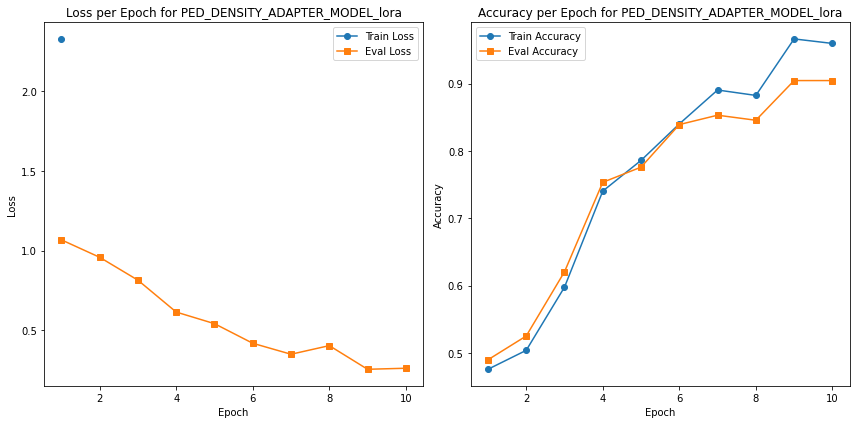

{'eval_loss': 0.2569071054458618, 'eval_accuracy': 0.9046087888531619, 'eval_f1': 0.9046726062975986, 'eval_precision': 0.9065280115191304, 'eval_recall': 0.9046087888531619, 'eval_runtime': 32.7028, 'eval_samples_per_second': 28.53, 'eval_steps_per_second': 0.245, 'epoch': 9.633333333333333}

Training PED_DENSITY_ADAPTER_MODEL with adalora type...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model size: 344.39 MB
adalora Adapter trainable parameters: 297,411/86,098,398 (0.35%)
Number of Training Epochs: 10
Starting Epoch 1
Epoch 1 ending
Completed Epoch 1
{'eval_loss': 1.0723786354064941, 'eval_accuracy': 0.48981779206859594, 'eval_f1': 0.45877455179656723, 'eval_precision': 0.4775822247522298, 'eval_recall': 0.48981779206859594, 'eval_runtime': 33.3317, 'eval_samples_per_second': 27.991, 'eval_steps_per_second': 0.24, 'epoch': 0.9333333333333333}
Starting Epoch 2
Epoch 2 ending
Completed Epoch 2
{'eval_loss': 0.9950177669525146, 'eval_accuracy': 0.5359056806002144, 'eval_f1': 0.38475594430462495, 'eval_precision': 0.6001045720026547, 'eval_recall': 0.5359056806002144, 'eval_runtime': 32.9886, 'eval_samples_per_second': 28.282, 'eval_steps_per_second': 0.243, 'epoch': 1.9}
Starting Epoch 3
Epoch 3 ending
Completed Epoch 3
{'eval_loss': 0.9135695099830627, 'eval_accuracy': 0.5326902465166131, 'eval_f1': 0.38608802695411554, 'eval_precision': 0.44444461326022033, 'eval_recal

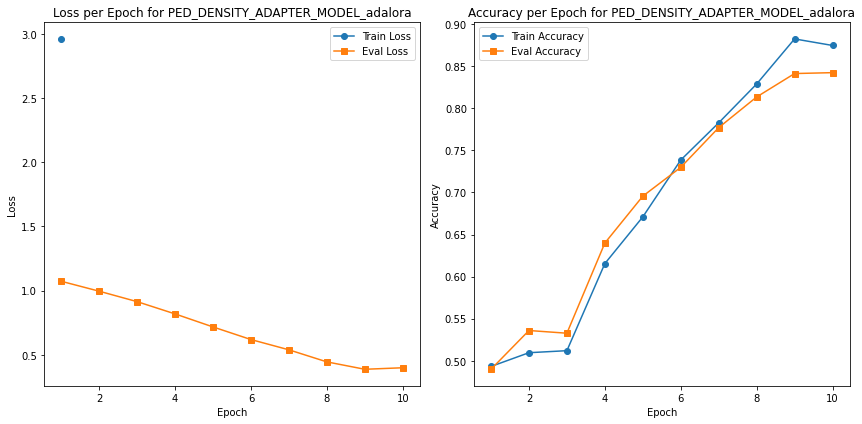

{'eval_loss': 0.3985784947872162, 'eval_accuracy': 0.842443729903537, 'eval_f1': 0.8450415476105385, 'eval_precision': 0.858539486767159, 'eval_recall': 0.842443729903537, 'eval_runtime': 32.6379, 'eval_samples_per_second': 28.586, 'eval_steps_per_second': 0.245, 'epoch': 9.633333333333333}

Training PED_DENSITY_ADAPTER_MODEL with ia3 type...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model size: 343.51 MB
ia3 Adapter trainable parameters: 76,035/85,876,998 (0.09%)
Number of Training Epochs: 10
Starting Epoch 1
Epoch 1 ending
Completed Epoch 1
{'eval_loss': 1.0680872201919556, 'eval_accuracy': 0.5176848874598071, 'eval_f1': 0.4796762228118528, 'eval_precision': 0.49335684256133494, 'eval_recall': 0.5176848874598071, 'eval_runtime': 32.9114, 'eval_samples_per_second': 28.349, 'eval_steps_per_second': 0.243, 'epoch': 0.9333333333333333}
Starting Epoch 2
Epoch 2 ending
Completed Epoch 2
{'eval_loss': 0.9810475707054138, 'eval_accuracy': 0.5337620578778135, 'eval_f1': 0.3802564087862747, 'eval_precision': 0.5927256023719045, 'eval_recall': 0.5337620578778135, 'eval_runtime': 33.1872, 'eval_samples_per_second': 28.113, 'eval_steps_per_second': 0.241, 'epoch': 1.9}
Starting Epoch 3
Epoch 3 ending
Completed Epoch 3
{'eval_loss': 0.8799763321876526, 'eval_accuracy': 0.5680600214362272, 'eval_f1': 0.4729268496518269, 'eval_precision': 0.5421482035802201, 'eval_recall': 0.568

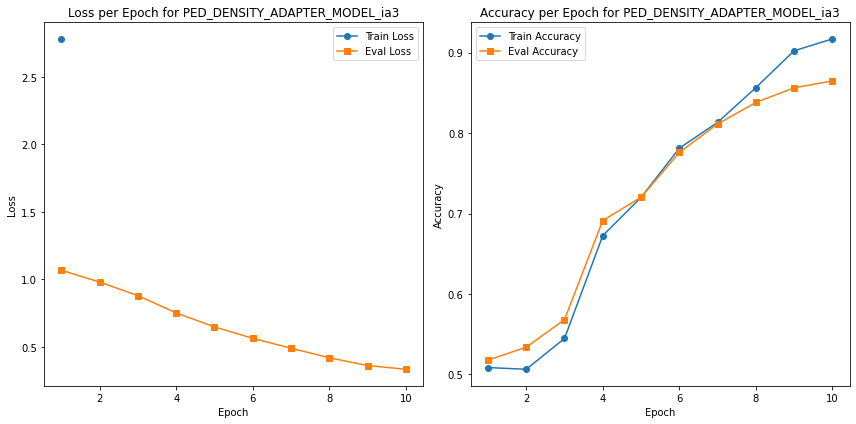

{'eval_loss': 0.33520209789276123, 'eval_accuracy': 0.864951768488746, 'eval_f1': 0.8635596006887615, 'eval_precision': 0.8630899972026361, 'eval_recall': 0.864951768488746, 'eval_runtime': 32.1263, 'eval_samples_per_second': 29.042, 'eval_steps_per_second': 0.249, 'epoch': 9.633333333333333}

Training PED_DENSITY_ADAPTER_MODEL with loha type...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model size: 345.57 MB
loha Adapter trainable parameters: 592,131/86,393,094 (0.69%)
Number of Training Epochs: 10
Starting Epoch 1
Epoch 1 ending
Completed Epoch 1
{'eval_loss': 1.0719348192214966, 'eval_accuracy': 0.4941050375133976, 'eval_f1': 0.46231974626618544, 'eval_precision': 0.48102385903412137, 'eval_recall': 0.4941050375133976, 'eval_runtime': 32.8797, 'eval_samples_per_second': 28.376, 'eval_steps_per_second': 0.243, 'epoch': 0.9333333333333333}
Starting Epoch 2
Epoch 2 ending
Completed Epoch 2
{'eval_loss': 0.9927893280982971, 'eval_accuracy': 0.5359056806002144, 'eval_f1': 0.38475594430462495, 'eval_precision': 0.6001045720026547, 'eval_recall': 0.5359056806002144, 'eval_runtime': 32.6958, 'eval_samples_per_second': 28.536, 'eval_steps_per_second': 0.245, 'epoch': 1.9}
Starting Epoch 3
Epoch 3 ending
Completed Epoch 3
{'eval_loss': 0.907961368560791, 'eval_accuracy': 0.5337620578778135, 'eval_f1': 0.39188828157245076, 'eval_precision': 0.4561133495036875, 'eval_recall': 0

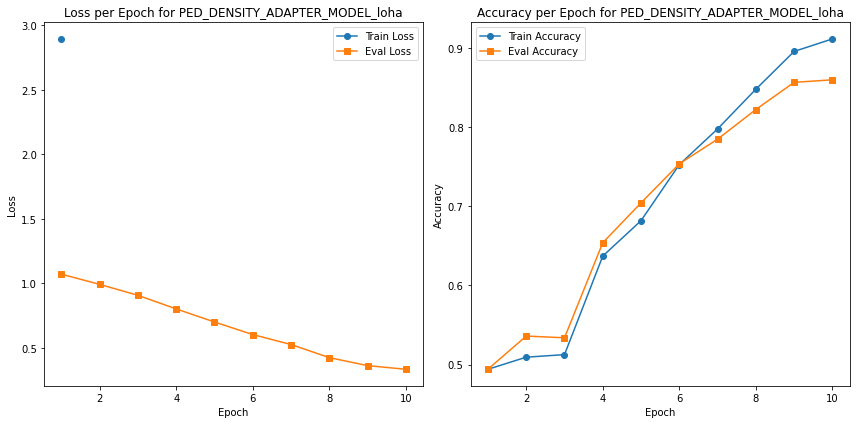

{'eval_loss': 0.3352925479412079, 'eval_accuracy': 0.8595927116827439, 'eval_f1': 0.8547031661409246, 'eval_precision': 0.8552604706511344, 'eval_recall': 0.8595927116827439, 'eval_runtime': 32.0484, 'eval_samples_per_second': 29.112, 'eval_steps_per_second': 0.25, 'epoch': 9.633333333333333}

Training PED_DENSITY_ADAPTER_MODEL with lokr type...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model size: 343.32 MB
lokr Adapter trainable parameters: 28,419/85,829,382 (0.03%)
Number of Training Epochs: 10
Starting Epoch 1
Epoch 1 ending
Completed Epoch 1
{'eval_loss': 1.0811834335327148, 'eval_accuracy': 0.4480171489817792, 'eval_f1': 0.415027301077747, 'eval_precision': 0.40320704280756847, 'eval_recall': 0.4480171489817792, 'eval_runtime': 32.9315, 'eval_samples_per_second': 28.332, 'eval_steps_per_second': 0.243, 'epoch': 0.9333333333333333}
Starting Epoch 2
Epoch 2 ending
Completed Epoch 2
{'eval_loss': 1.0009220838546753, 'eval_accuracy': 0.5273311897106109, 'eval_f1': 0.3646478500880121, 'eval_precision': 0.2786755589018481, 'eval_recall': 0.5273311897106109, 'eval_runtime': 32.5251, 'eval_samples_per_second': 28.686, 'eval_steps_per_second': 0.246, 'epoch': 1.9}
Starting Epoch 3
Epoch 3 ending
Completed Epoch 3
{'eval_loss': 0.9141125082969666, 'eval_accuracy': 0.5359056806002144, 'eval_f1': 0.38816225820446076, 'eval_precision': 0.4588011202173278, 'eval_recall': 0.53

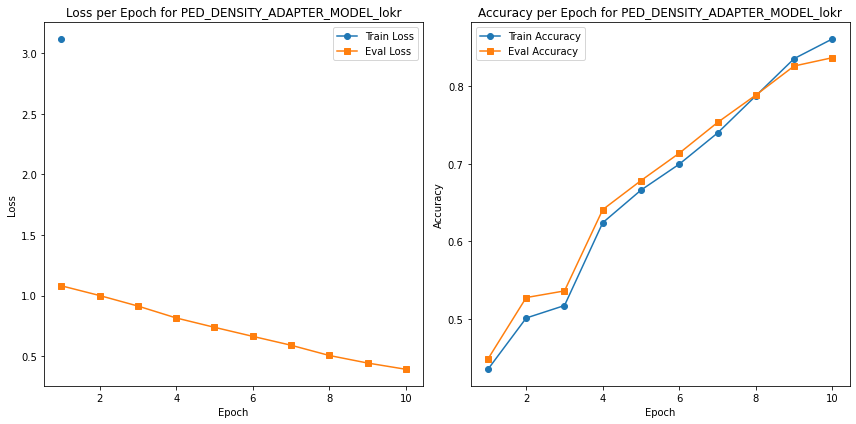

{'eval_loss': 0.39256930351257324, 'eval_accuracy': 0.8370846730975349, 'eval_f1': 0.8356548708836724, 'eval_precision': 0.8352214028121477, 'eval_recall': 0.8370846730975349, 'eval_runtime': 32.8037, 'eval_samples_per_second': 28.442, 'eval_steps_per_second': 0.244, 'epoch': 9.633333333333333}

Training PRESENCE_ADAPTER_MODEL with lora type...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model size: 344.39 MB
lora Adapter trainable parameters: 296,450/86,096,644 (0.34%)
Number of Training Epochs: 3
Starting Epoch 1
Epoch 1 ending
Completed Epoch 1
{'eval_loss': 0.6848278641700745, 'eval_accuracy': 0.6425, 'eval_f1': 0.6333363201911589, 'eval_precision': 0.6638612194257355, 'eval_recall': 0.6425, 'eval_runtime': 28.7985, 'eval_samples_per_second': 27.779, 'eval_steps_per_second': 0.243, 'epoch': 0.96}
Starting Epoch 2
Epoch 2 ending
Completed Epoch 2
{'eval_loss': 0.5743200778961182, 'eval_accuracy': 0.9325, 'eval_f1': 0.9323127400768246, 'eval_precision': 0.9355307427711491, 'eval_recall': 0.9325, 'eval_runtime': 26.761, 'eval_samples_per_second': 29.894, 'eval_steps_per_second': 0.262, 'epoch': 1.92}
Starting Epoch 3
Epoch 3 ending
Completed Epoch 3
{'eval_loss': 0.3449937403202057, 'eval_accuracy': 0.9125, 'eval_f1': 0.9116474972163175, 'eval_precision': 0.9252870563674321, 'eval_recall': 0.9125, 'eval_runtime': 27.275, 'eval_samples_per_second': 29.331, 'eval_steps_

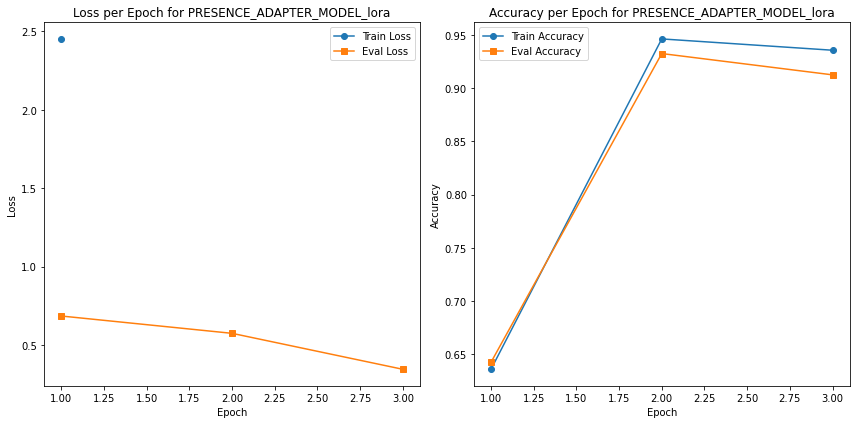

{'eval_loss': 0.5743200778961182, 'eval_accuracy': 0.9325, 'eval_f1': 0.9323127400768246, 'eval_precision': 0.9355307427711491, 'eval_recall': 0.9325, 'eval_runtime': 27.7369, 'eval_samples_per_second': 28.842, 'eval_steps_per_second': 0.252, 'epoch': 2.88}

Training PRESENCE_ADAPTER_MODEL with adalora type...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model size: 344.39 MB
adalora Adapter trainable parameters: 296,642/86,096,860 (0.34%)
Number of Training Epochs: 3
Starting Epoch 1
Epoch 1 ending
Completed Epoch 1
{'eval_loss': 0.6582903861999512, 'eval_accuracy': 0.71375, 'eval_f1': 0.7137576035275055, 'eval_precision': 0.7144100765306122, 'eval_recall': 0.71375, 'eval_runtime': 27.1928, 'eval_samples_per_second': 29.42, 'eval_steps_per_second': 0.257, 'epoch': 0.96}
Starting Epoch 2
Epoch 2 ending
Completed Epoch 2
{'eval_loss': 0.5879748463630676, 'eval_accuracy': 0.89375, 'eval_f1': 0.8936137092997578, 'eval_precision': 0.8947151948460088, 'eval_recall': 0.89375, 'eval_runtime': 27.1475, 'eval_samples_per_second': 29.469, 'eval_steps_per_second': 0.258, 'epoch': 1.92}
Starting Epoch 3
Epoch 3 ending
Completed Epoch 3
{'eval_loss': 0.48386260867118835, 'eval_accuracy': 0.94875, 'eval_f1': 0.9486146785608386, 'eval_precision': 0.9517421604438939, 'eval_recall': 0.94875, 'eval_runtime': 27.2525, 'eval_samples_per_second': 29.355, '

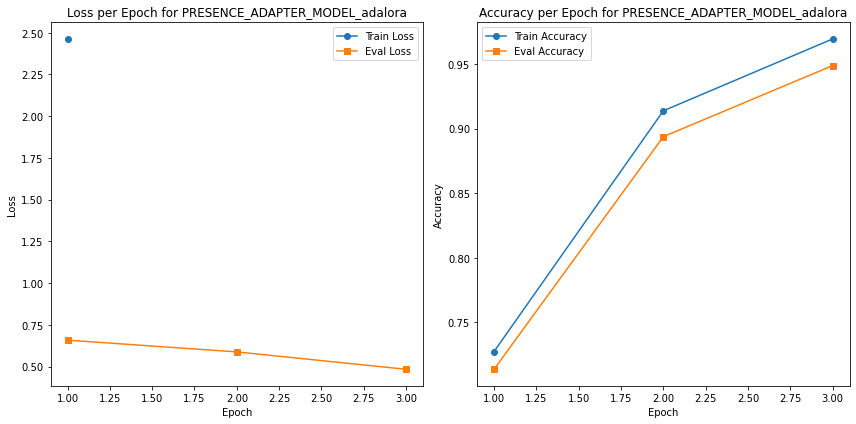

{'eval_loss': 0.48386260867118835, 'eval_accuracy': 0.94875, 'eval_f1': 0.9486146785608386, 'eval_precision': 0.9517421604438939, 'eval_recall': 0.94875, 'eval_runtime': 27.1705, 'eval_samples_per_second': 29.444, 'eval_steps_per_second': 0.258, 'epoch': 2.88}

Training PRESENCE_ADAPTER_MODEL with ia3 type...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model size: 343.50 MB
ia3 Adapter trainable parameters: 75,266/85,875,460 (0.09%)
Number of Training Epochs: 3
Starting Epoch 1
Epoch 1 ending
Completed Epoch 1
{'eval_loss': 0.652750551700592, 'eval_accuracy': 0.73125, 'eval_f1': 0.7312823364601351, 'eval_precision': 0.7315911804045101, 'eval_recall': 0.73125, 'eval_runtime': 27.3944, 'eval_samples_per_second': 29.203, 'eval_steps_per_second': 0.256, 'epoch': 0.96}
Starting Epoch 2
Epoch 2 ending
Completed Epoch 2
{'eval_loss': 0.5640249848365784, 'eval_accuracy': 0.9375, 'eval_f1': 0.9373431372549019, 'eval_precision': 0.9402160353463578, 'eval_recall': 0.9375, 'eval_runtime': 27.1705, 'eval_samples_per_second': 29.444, 'eval_steps_per_second': 0.258, 'epoch': 1.92}
Starting Epoch 3
Epoch 3 ending
Completed Epoch 3
{'eval_loss': 0.4266001880168915, 'eval_accuracy': 0.9725, 'eval_f1': 0.9724720997519978, 'eval_precision': 0.9734332207369829, 'eval_recall': 0.9725, 'eval_runtime': 26.9072, 'eval_samples_per_second': 29.732, 'eval_steps

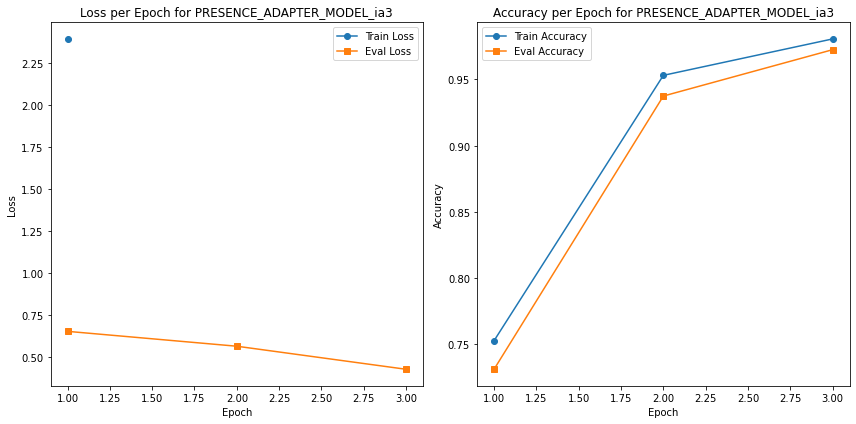

{'eval_loss': 0.4266001880168915, 'eval_accuracy': 0.9725, 'eval_f1': 0.9724720997519978, 'eval_precision': 0.9734332207369829, 'eval_recall': 0.9725, 'eval_runtime': 26.9507, 'eval_samples_per_second': 29.684, 'eval_steps_per_second': 0.26, 'epoch': 2.88}

Training PRESENCE_ADAPTER_MODEL with loha type...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model size: 345.57 MB
loha Adapter trainable parameters: 591,362/86,391,556 (0.68%)
Number of Training Epochs: 3
Starting Epoch 1
Epoch 1 ending
Completed Epoch 1
{'eval_loss': 0.6577871441841125, 'eval_accuracy': 0.71625, 'eval_f1': 0.7162575371211517, 'eval_precision': 0.7169122023809524, 'eval_recall': 0.71625, 'eval_runtime': 27.498, 'eval_samples_per_second': 29.093, 'eval_steps_per_second': 0.255, 'epoch': 0.96}
Starting Epoch 2
Epoch 2 ending
Completed Epoch 2
{'eval_loss': 0.5845059156417847, 'eval_accuracy': 0.90125, 'eval_f1': 0.9010836502645926, 'eval_precision': 0.9026889117624839, 'eval_recall': 0.90125, 'eval_runtime': 26.786, 'eval_samples_per_second': 29.866, 'eval_steps_per_second': 0.261, 'epoch': 1.92}
Starting Epoch 3
Epoch 3 ending
Completed Epoch 3
{'eval_loss': 0.4734054505825043, 'eval_accuracy': 0.95125, 'eval_f1': 0.9511338592124516, 'eval_precision': 0.9539018308080807, 'eval_recall': 0.95125, 'eval_runtime': 26.9984, 'eval_samples_per_second': 29.631, 'eval_

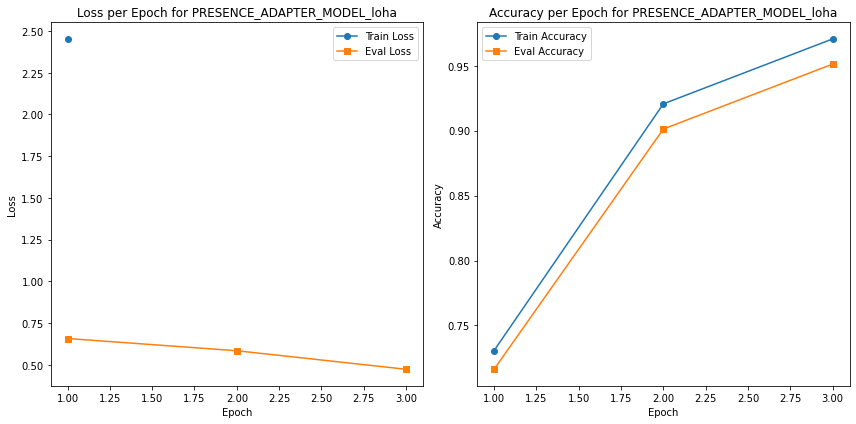

{'eval_loss': 0.4734054505825043, 'eval_accuracy': 0.95125, 'eval_f1': 0.9511338592124516, 'eval_precision': 0.9539018308080807, 'eval_recall': 0.95125, 'eval_runtime': 26.6232, 'eval_samples_per_second': 30.049, 'eval_steps_per_second': 0.263, 'epoch': 2.88}

Training PRESENCE_ADAPTER_MODEL with lokr type...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model size: 343.31 MB
lokr Adapter trainable parameters: 27,650/85,827,844 (0.03%)
Number of Training Epochs: 3
Starting Epoch 1
Epoch 1 ending
Completed Epoch 1
{'eval_loss': 0.6683434844017029, 'eval_accuracy': 0.73, 'eval_f1': 0.7239455327281413, 'eval_precision': 0.7579716673866386, 'eval_recall': 0.73, 'eval_runtime': 27.5122, 'eval_samples_per_second': 29.078, 'eval_steps_per_second': 0.254, 'epoch': 0.96}
Starting Epoch 2
Epoch 2 ending
Completed Epoch 2
{'eval_loss': 0.5935861468315125, 'eval_accuracy': 0.91875, 'eval_f1': 0.9187557148997695, 'eval_precision': 0.9187872740116526, 'eval_recall': 0.91875, 'eval_runtime': 27.4637, 'eval_samples_per_second': 29.129, 'eval_steps_per_second': 0.255, 'epoch': 1.92}
Starting Epoch 3
Epoch 3 ending
Completed Epoch 3
{'eval_loss': 0.48253387212753296, 'eval_accuracy': 0.9325, 'eval_f1': 0.9323933936662927, 'eval_precision': 0.9339759204837929, 'eval_recall': 0.9325, 'eval_runtime': 27.1503, 'eval_samples_per_second': 29.466, 'eval_steps_

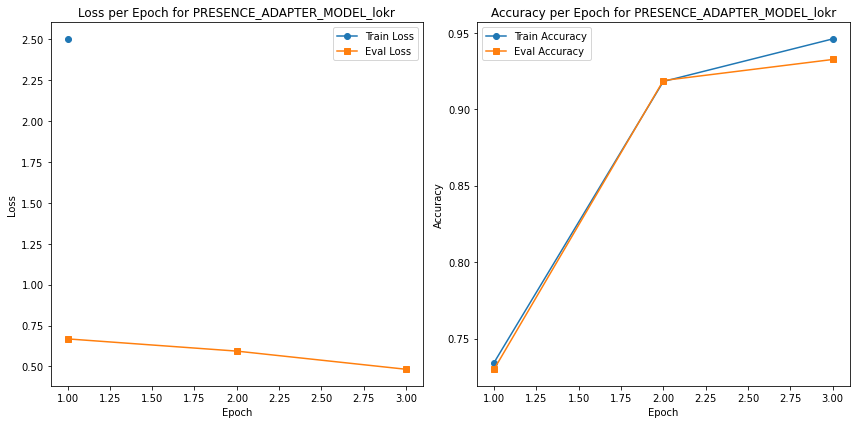

{'eval_loss': 0.48253387212753296, 'eval_accuracy': 0.9325, 'eval_f1': 0.9323933936662927, 'eval_precision': 0.9339759204837929, 'eval_recall': 0.9325, 'eval_runtime': 27.0024, 'eval_samples_per_second': 29.627, 'eval_steps_per_second': 0.259, 'epoch': 2.88}

Training TIME_OF_DAY_ADAPTER_MODEL with lora type...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model size: 344.39 MB
lora Adapter trainable parameters: 296,450/86,096,644 (0.34%)
Number of Training Epochs: 3
Starting Epoch 1
Epoch 1 ending
Completed Epoch 1
{'eval_loss': 0.6793789863586426, 'eval_accuracy': 0.6535326086956522, 'eval_f1': 0.6414712845113261, 'eval_precision': 0.6379726216540217, 'eval_recall': 0.6535326086956522, 'eval_runtime': 26.6789, 'eval_samples_per_second': 27.587, 'eval_steps_per_second': 0.225, 'epoch': 0.8695652173913043}
Starting Epoch 2
Epoch 2 ending
Completed Epoch 2
{'eval_loss': 0.5811907052993774, 'eval_accuracy': 0.9130434782608695, 'eval_f1': 0.9096800542952725, 'eval_precision': 0.9233494363929147, 'eval_recall': 0.9130434782608695, 'eval_runtime': 24.6178, 'eval_samples_per_second': 29.897, 'eval_steps_per_second': 0.244, 'epoch': 1.9130434782608696}
Starting Epoch 3
Epoch 3 ending
Completed Epoch 3
{'eval_loss': 0.4488299787044525, 'eval_accuracy': 0.9184782608695652, 'eval_f1': 0.9155782780546484, 'eval_precision': 0.9276038286826735, 'eval

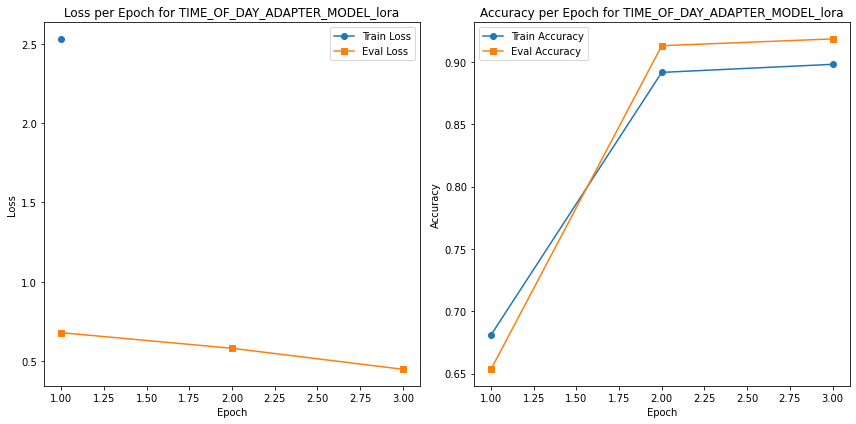

{'eval_loss': 0.4488299787044525, 'eval_accuracy': 0.9184782608695652, 'eval_f1': 0.9155782780546484, 'eval_precision': 0.9276038286826735, 'eval_recall': 0.9184782608695652, 'eval_runtime': 24.7201, 'eval_samples_per_second': 29.773, 'eval_steps_per_second': 0.243, 'epoch': 2.608695652173913}

Training TIME_OF_DAY_ADAPTER_MODEL with adalora type...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model size: 344.39 MB
adalora Adapter trainable parameters: 296,642/86,096,860 (0.34%)
Number of Training Epochs: 3
Starting Epoch 1
Epoch 1 ending
Completed Epoch 1
{'eval_loss': 0.6790233850479126, 'eval_accuracy': 0.6752717391304348, 'eval_f1': 0.6818353793380924, 'eval_precision': 0.7354156995085303, 'eval_recall': 0.6752717391304348, 'eval_runtime': 24.9928, 'eval_samples_per_second': 29.449, 'eval_steps_per_second': 0.24, 'epoch': 0.8695652173913043}
Starting Epoch 2
Epoch 2 ending
Completed Epoch 2
{'eval_loss': 0.612827479839325, 'eval_accuracy': 0.8478260869565217, 'eval_f1': 0.8356332183789037, 'eval_precision': 0.87353452869816, 'eval_recall': 0.8478260869565217, 'eval_runtime': 25.1042, 'eval_samples_per_second': 29.318, 'eval_steps_per_second': 0.239, 'epoch': 1.9130434782608696}
Starting Epoch 3
Epoch 3 ending
Completed Epoch 3
{'eval_loss': 0.55068039894104, 'eval_accuracy': 0.8858695652173914, 'eval_f1': 0.8795022585409502, 'eval_precision': 0.9029891304347825, 'eval_re

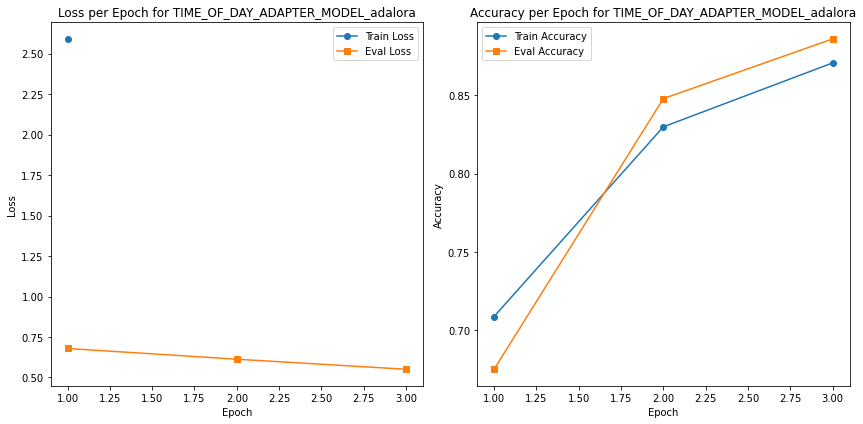

{'eval_loss': 0.55068039894104, 'eval_accuracy': 0.8858695652173914, 'eval_f1': 0.8795022585409502, 'eval_precision': 0.9029891304347825, 'eval_recall': 0.8858695652173914, 'eval_runtime': 24.5501, 'eval_samples_per_second': 29.98, 'eval_steps_per_second': 0.244, 'epoch': 2.608695652173913}

Training TIME_OF_DAY_ADAPTER_MODEL with ia3 type...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model size: 343.50 MB
ia3 Adapter trainable parameters: 75,266/85,875,460 (0.09%)
Number of Training Epochs: 3
Starting Epoch 1
Epoch 1 ending
Completed Epoch 1
{'eval_loss': 0.6730486154556274, 'eval_accuracy': 0.7119565217391305, 'eval_f1': 0.7182407600027737, 'eval_precision': 0.759686247301881, 'eval_recall': 0.7119565217391305, 'eval_runtime': 24.7622, 'eval_samples_per_second': 29.723, 'eval_steps_per_second': 0.242, 'epoch': 0.8695652173913043}
Starting Epoch 2
Epoch 2 ending
Completed Epoch 2
{'eval_loss': 0.5893710851669312, 'eval_accuracy': 0.8940217391304348, 'eval_f1': 0.8886834852134184, 'eval_precision': 0.9089428661120703, 'eval_recall': 0.8940217391304348, 'eval_runtime': 24.5293, 'eval_samples_per_second': 30.005, 'eval_steps_per_second': 0.245, 'epoch': 1.9130434782608696}
Starting Epoch 3
Epoch 3 ending
Completed Epoch 3
{'eval_loss': 0.5067636370658875, 'eval_accuracy': 0.9130434782608695, 'eval_f1': 0.9096800542952725, 'eval_precision': 0.9233494363929147, 'eval_re

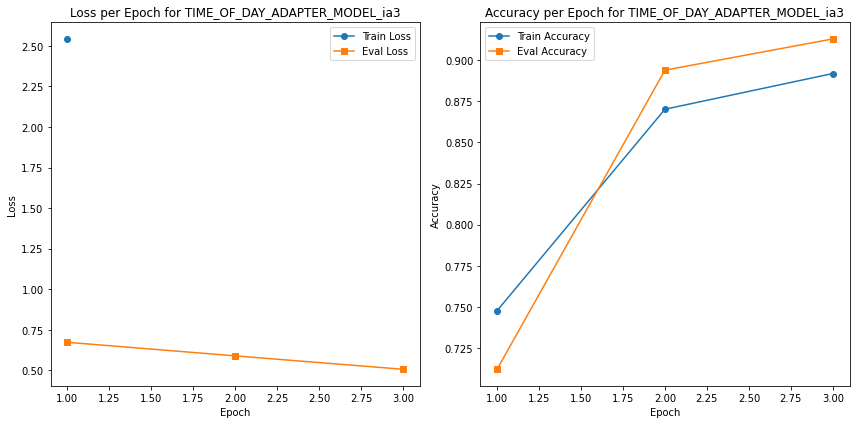

{'eval_loss': 0.5067636370658875, 'eval_accuracy': 0.9130434782608695, 'eval_f1': 0.9096800542952725, 'eval_precision': 0.9233494363929147, 'eval_recall': 0.9130434782608695, 'eval_runtime': 25.0283, 'eval_samples_per_second': 29.407, 'eval_steps_per_second': 0.24, 'epoch': 2.608695652173913}

Training TIME_OF_DAY_ADAPTER_MODEL with loha type...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model size: 345.57 MB
loha Adapter trainable parameters: 591,362/86,391,556 (0.68%)
Number of Training Epochs: 3
Starting Epoch 1
Epoch 1 ending
Completed Epoch 1
{'eval_loss': 0.6787235140800476, 'eval_accuracy': 0.6779891304347826, 'eval_f1': 0.6845691314788102, 'eval_precision': 0.73692799513232, 'eval_recall': 0.6779891304347826, 'eval_runtime': 25.2711, 'eval_samples_per_second': 29.124, 'eval_steps_per_second': 0.237, 'epoch': 0.8695652173913043}
Starting Epoch 2
Epoch 2 ending
Completed Epoch 2
{'eval_loss': 0.6096755266189575, 'eval_accuracy': 0.8573369565217391, 'eval_f1': 0.8466820197252459, 'eval_precision': 0.8815826258185385, 'eval_recall': 0.8573369565217391, 'eval_runtime': 24.6009, 'eval_samples_per_second': 29.918, 'eval_steps_per_second': 0.244, 'epoch': 1.9130434782608696}
Starting Epoch 3
Epoch 3 ending
Completed Epoch 3
{'eval_loss': 0.5437303781509399, 'eval_accuracy': 0.9008152173913043, 'eval_f1': 0.8962481821783493, 'eval_precision': 0.9140037221826245, 'eval_r

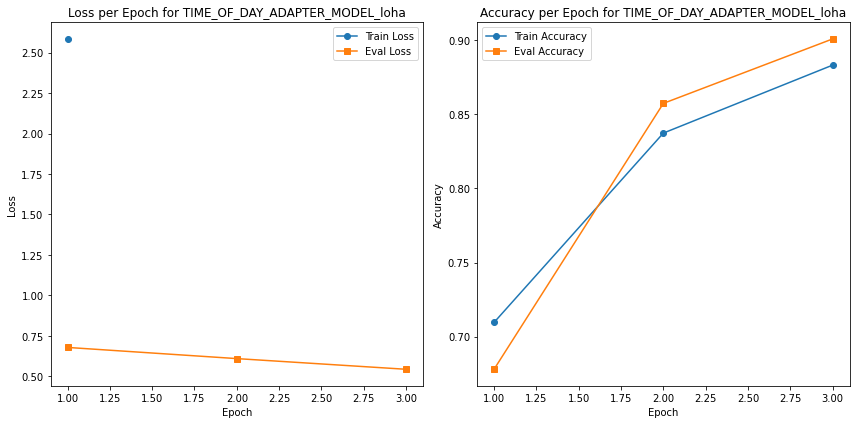

{'eval_loss': 0.5437303781509399, 'eval_accuracy': 0.9008152173913043, 'eval_f1': 0.8962481821783493, 'eval_precision': 0.9140037221826245, 'eval_recall': 0.9008152173913043, 'eval_runtime': 24.671, 'eval_samples_per_second': 29.833, 'eval_steps_per_second': 0.243, 'epoch': 2.608695652173913}

Training TIME_OF_DAY_ADAPTER_MODEL with lokr type...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model size: 343.31 MB
lokr Adapter trainable parameters: 27,650/85,827,844 (0.03%)
Number of Training Epochs: 3
Starting Epoch 1
Epoch 1 ending
Completed Epoch 1
{'eval_loss': 0.67481929063797, 'eval_accuracy': 0.657608695652174, 'eval_f1': 0.6294102845228895, 'eval_precision': 0.6330291338972153, 'eval_recall': 0.657608695652174, 'eval_runtime': 24.631, 'eval_samples_per_second': 29.881, 'eval_steps_per_second': 0.244, 'epoch': 0.8695652173913043}
Starting Epoch 2
Epoch 2 ending
Completed Epoch 2
{'eval_loss': 0.6112173199653625, 'eval_accuracy': 0.7717391304347826, 'eval_f1': 0.7366905797174128, 'eval_precision': 0.8219257718079735, 'eval_recall': 0.7717391304347826, 'eval_runtime': 24.7435, 'eval_samples_per_second': 29.745, 'eval_steps_per_second': 0.242, 'epoch': 1.9130434782608696}
Starting Epoch 3
Epoch 3 ending
Completed Epoch 3
{'eval_loss': 0.5496461391448975, 'eval_accuracy': 0.8029891304347826, 'eval_f1': 0.7779206795872803, 'eval_precision': 0.848990058111041, 'eval_recall

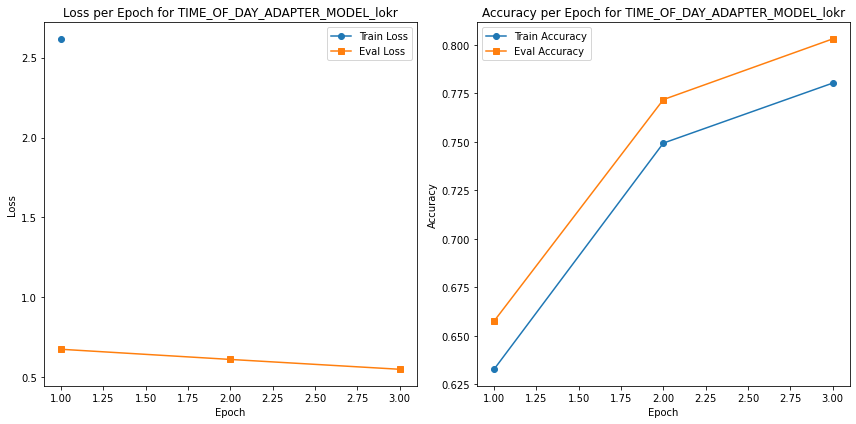

{'eval_loss': 0.5496461391448975, 'eval_accuracy': 0.8029891304347826, 'eval_f1': 0.7779206795872803, 'eval_precision': 0.848990058111041, 'eval_recall': 0.8029891304347826, 'eval_runtime': 24.7068, 'eval_samples_per_second': 29.789, 'eval_steps_per_second': 0.243, 'epoch': 2.608695652173913}

Training WEATHER_ADAPTER_MODEL with lora type...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model size: 344.40 MB
lora Adapter trainable parameters: 297,988/86,099,720 (0.35%)
Number of Training Epochs: 3
Starting Epoch 1
Epoch 1 ending
Completed Epoch 1
{'eval_loss': 1.2689284086227417, 'eval_accuracy': 0.6233333333333333, 'eval_f1': 0.632667708966178, 'eval_precision': 0.715220124918012, 'eval_recall': 0.6233333333333333, 'eval_runtime': 54.797, 'eval_samples_per_second': 27.374, 'eval_steps_per_second': 0.219, 'epoch': 0.9361702127659575}
Starting Epoch 2
Epoch 2 ending
Completed Epoch 2
{'eval_loss': 0.7426074147224426, 'eval_accuracy': 0.8706666666666667, 'eval_f1': 0.8726484508986634, 'eval_precision': 0.8846253715699385, 'eval_recall': 0.8706666666666667, 'eval_runtime': 51.5482, 'eval_samples_per_second': 29.099, 'eval_steps_per_second': 0.233, 'epoch': 1.9574468085106385}
Starting Epoch 3
Epoch 3 ending
Completed Epoch 3
{'eval_loss': 0.1105303168296814, 'eval_accuracy': 0.9913333333333333, 'eval_f1': 0.9913377360783202, 'eval_precision': 0.9915101620601621, 'eval_re

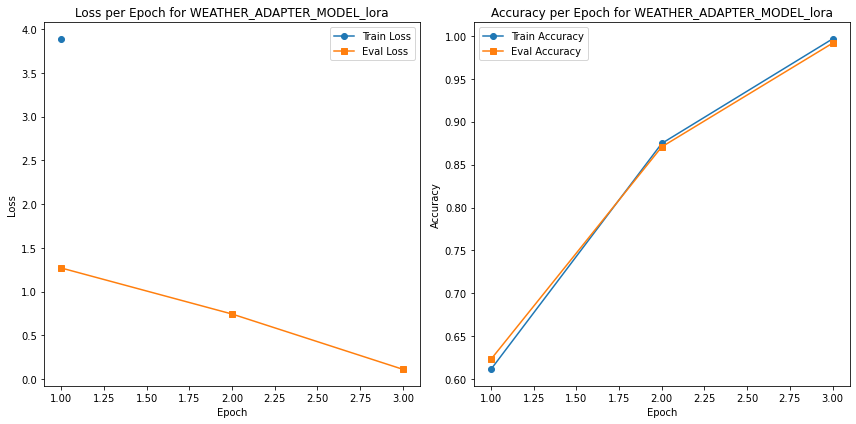

{'eval_loss': 0.1105303168296814, 'eval_accuracy': 0.9913333333333333, 'eval_f1': 0.9913377360783202, 'eval_precision': 0.9915101620601621, 'eval_recall': 0.9913333333333333, 'eval_runtime': 51.2385, 'eval_samples_per_second': 29.275, 'eval_steps_per_second': 0.234, 'epoch': 2.8085106382978724}

Training WEATHER_ADAPTER_MODEL with adalora type...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model size: 344.40 MB
adalora Adapter trainable parameters: 298,180/86,099,936 (0.35%)
Number of Training Epochs: 3
Starting Epoch 1
Epoch 1 ending
Completed Epoch 1
{'eval_loss': 1.2994853258132935, 'eval_accuracy': 0.5626666666666666, 'eval_f1': 0.5426496684897489, 'eval_precision': 0.6085909165310437, 'eval_recall': 0.5626666666666666, 'eval_runtime': 51.3933, 'eval_samples_per_second': 29.187, 'eval_steps_per_second': 0.233, 'epoch': 0.9361702127659575}
Starting Epoch 2
Epoch 2 ending
Completed Epoch 2
{'eval_loss': 1.0680465698242188, 'eval_accuracy': 0.752, 'eval_f1': 0.7572596350247144, 'eval_precision': 0.7924794876066139, 'eval_recall': 0.752, 'eval_runtime': 50.8653, 'eval_samples_per_second': 29.49, 'eval_steps_per_second': 0.236, 'epoch': 1.9574468085106385}
Starting Epoch 3
Epoch 3 ending
Completed Epoch 3
{'eval_loss': 0.7577942609786987, 'eval_accuracy': 0.8046666666666666, 'eval_f1': 0.8076684600494596, 'eval_precision': 0.8378985993925321, 'eval_recall': 0.804666666666

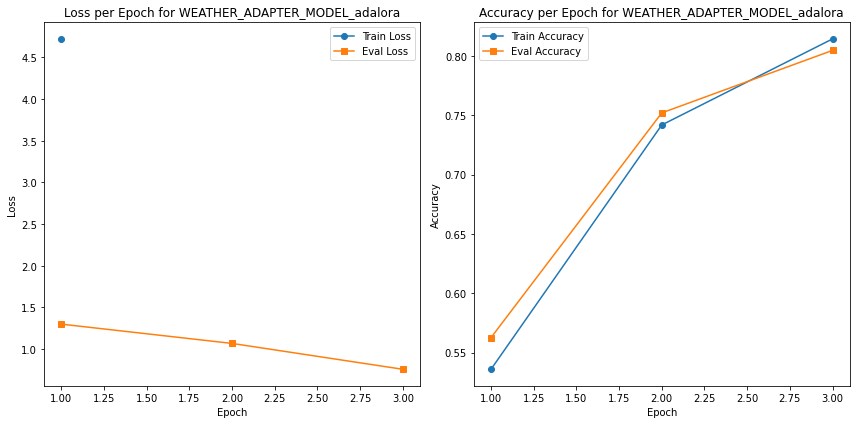

{'eval_loss': 0.7577942609786987, 'eval_accuracy': 0.8046666666666666, 'eval_f1': 0.8076684600494596, 'eval_precision': 0.8378985993925321, 'eval_recall': 0.8046666666666666, 'eval_runtime': 52.3296, 'eval_samples_per_second': 28.664, 'eval_steps_per_second': 0.229, 'epoch': 2.8085106382978724}

Training WEATHER_ADAPTER_MODEL with ia3 type...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model size: 343.51 MB
ia3 Adapter trainable parameters: 76,804/85,878,536 (0.09%)
Number of Training Epochs: 3
Starting Epoch 1
Epoch 1 ending
Completed Epoch 1
{'eval_loss': 1.284814476966858, 'eval_accuracy': 0.602, 'eval_f1': 0.5863568540646661, 'eval_precision': 0.6552352001980684, 'eval_recall': 0.602, 'eval_runtime': 51.8367, 'eval_samples_per_second': 28.937, 'eval_steps_per_second': 0.231, 'epoch': 0.9361702127659575}
Starting Epoch 2
Epoch 2 ending
Completed Epoch 2
{'eval_loss': 0.9777184128761292, 'eval_accuracy': 0.7973333333333333, 'eval_f1': 0.8013583813641741, 'eval_precision': 0.8431455549708936, 'eval_recall': 0.7973333333333333, 'eval_runtime': 51.916, 'eval_samples_per_second': 28.893, 'eval_steps_per_second': 0.231, 'epoch': 1.9574468085106385}
Starting Epoch 3
Epoch 3 ending
Completed Epoch 3
{'eval_loss': 0.5858122706413269, 'eval_accuracy': 0.918, 'eval_f1': 0.9180926004064128, 'eval_precision': 0.9200414485019527, 'eval_recall': 0.918, 'eval_runtime': 51.1624, '

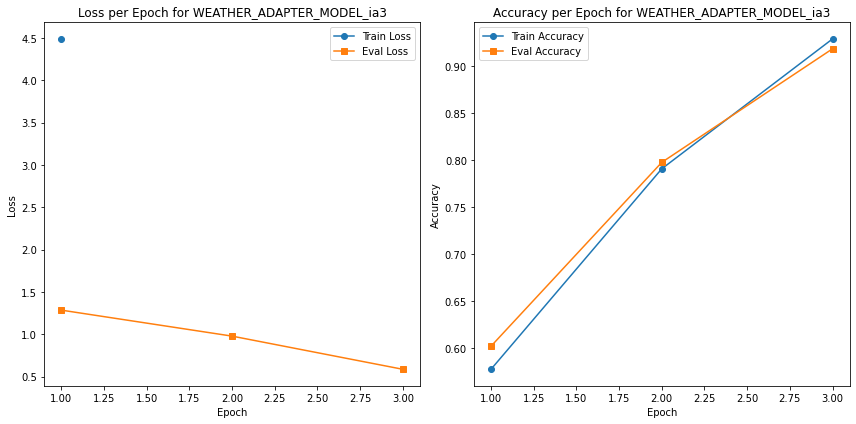

{'eval_loss': 0.5858122706413269, 'eval_accuracy': 0.918, 'eval_f1': 0.9180926004064128, 'eval_precision': 0.9200414485019527, 'eval_recall': 0.918, 'eval_runtime': 52.1988, 'eval_samples_per_second': 28.736, 'eval_steps_per_second': 0.23, 'epoch': 2.8085106382978724}

Training WEATHER_ADAPTER_MODEL with loha type...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model size: 345.58 MB
loha Adapter trainable parameters: 592,900/86,394,632 (0.69%)
Number of Training Epochs: 3
Starting Epoch 1
Epoch 1 ending
Completed Epoch 1
{'eval_loss': 1.2975645065307617, 'eval_accuracy': 0.5673333333333334, 'eval_f1': 0.5482059581988389, 'eval_precision': 0.6138342275772729, 'eval_recall': 0.5673333333333334, 'eval_runtime': 53.2763, 'eval_samples_per_second': 28.155, 'eval_steps_per_second': 0.225, 'epoch': 0.9361702127659575}
Starting Epoch 2
Epoch 2 ending
Completed Epoch 2
{'eval_loss': 1.0486308336257935, 'eval_accuracy': 0.7606666666666667, 'eval_f1': 0.7660982487466386, 'eval_precision': 0.8048936132154882, 'eval_recall': 0.7606666666666667, 'eval_runtime': 52.2159, 'eval_samples_per_second': 28.727, 'eval_steps_per_second': 0.23, 'epoch': 1.9574468085106385}
Starting Epoch 3
Epoch 3 ending
Completed Epoch 3
{'eval_loss': 0.7047034502029419, 'eval_accuracy': 0.8413333333333334, 'eval_f1': 0.8425922439165718, 'eval_precision': 0.8628989416522326, 'eval_

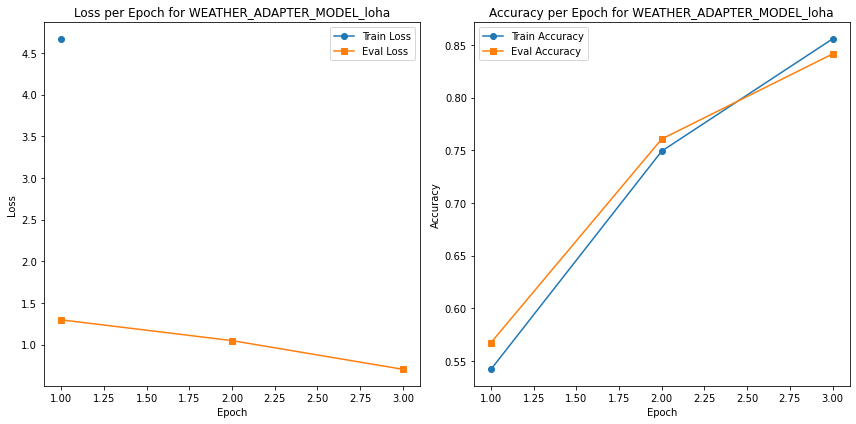

{'eval_loss': 0.7047034502029419, 'eval_accuracy': 0.8413333333333334, 'eval_f1': 0.8425922439165718, 'eval_precision': 0.8628989416522326, 'eval_recall': 0.8413333333333334, 'eval_runtime': 52.2111, 'eval_samples_per_second': 28.73, 'eval_steps_per_second': 0.23, 'epoch': 2.8085106382978724}

Training WEATHER_ADAPTER_MODEL with lokr type...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model size: 343.32 MB
lokr Adapter trainable parameters: 29,188/85,830,920 (0.03%)
Number of Training Epochs: 3
Starting Epoch 1
Epoch 1 ending
Completed Epoch 1
{'eval_loss': 1.3057727813720703, 'eval_accuracy': 0.5473333333333333, 'eval_f1': 0.5265487682629518, 'eval_precision': 0.6227678260853794, 'eval_recall': 0.5473333333333333, 'eval_runtime': 52.0723, 'eval_samples_per_second': 28.806, 'eval_steps_per_second': 0.23, 'epoch': 0.9361702127659575}
Starting Epoch 2
Epoch 2 ending
Completed Epoch 2
{'eval_loss': 1.0627903938293457, 'eval_accuracy': 0.74, 'eval_f1': 0.7459925006175584, 'eval_precision': 0.7889897498436523, 'eval_recall': 0.74, 'eval_runtime': 53.1709, 'eval_samples_per_second': 28.211, 'eval_steps_per_second': 0.226, 'epoch': 1.9574468085106385}
Starting Epoch 3
Epoch 3 ending
Completed Epoch 3
{'eval_loss': 0.7791910767555237, 'eval_accuracy': 0.794, 'eval_f1': 0.7973098203244984, 'eval_precision': 0.8152627591845067, 'eval_recall': 0.794, 'eval_runtime': 52.9708, '

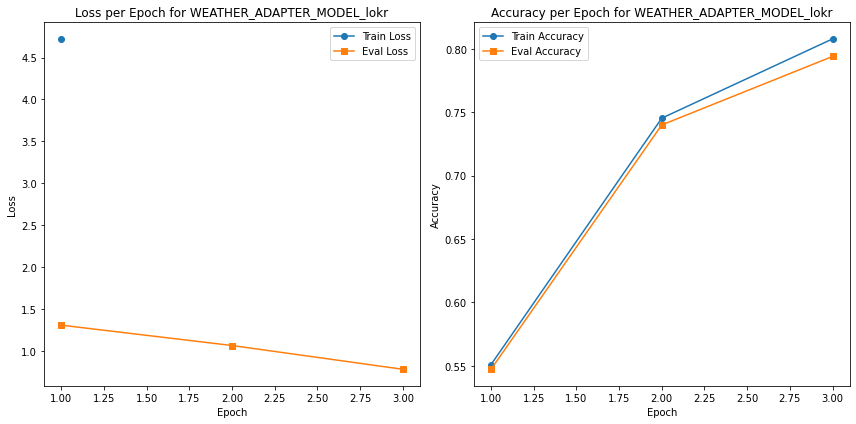

{'eval_loss': 0.7791910767555237, 'eval_accuracy': 0.794, 'eval_f1': 0.7973098203244984, 'eval_precision': 0.8152627591845067, 'eval_recall': 0.794, 'eval_runtime': 51.8096, 'eval_samples_per_second': 28.952, 'eval_steps_per_second': 0.232, 'epoch': 2.8085106382978724}


In [20]:
results = {}
for adapter_type in config.keys():
    for lora_type in adapter_configs.keys():
        print(f"\nTraining {adapter_type} with {lora_type} type...")
        metrics = train_model_with_adapter(adapter_type, lora_type)
        results[f"{adapter_type}_{lora_type}"] = metrics

In [21]:
def display_results_as_table(results):
    rows = []
    for model_adapter, metrics in results.items():
        adapter_type, lora_type = model_adapter.split("_", 1)
        row = {
            "Adapter": adapter_type,
            "LoRA Type": lora_type,
            "Eval Loss": metrics.get("eval_loss", None),
            "Eval Accuracy": metrics.get("eval_accuracy", None),
            "Eval F1": metrics.get("eval_f1", None),
            "Eval Precision": metrics.get("eval_precision", None),
            "Eval Recall": metrics.get("eval_recall", None),
            "Epoch": metrics.get("epoch", None)
        }
        rows.append(row)
    df = pd.DataFrame(rows)
    df = df.sort_values(by=["Adapter", "LoRA Type"])
    print("\n=== Comparison of All Adapter and LoRA Models ===")
    print(df.to_string(index=False))

display_results_as_table(results)


=== Comparison of All Adapter and LoRA Models ===
 Adapter                     LoRA Type  Eval Loss  Eval Accuracy  Eval F1  Eval Precision  Eval Recall    Epoch
     PED DENSITY_ADAPTER_MODEL_adalora   0.398578       0.842444 0.845042        0.858539     0.842444 9.633333
     PED     DENSITY_ADAPTER_MODEL_ia3   0.335202       0.864952 0.863560        0.863090     0.864952 9.633333
     PED    DENSITY_ADAPTER_MODEL_loha   0.335293       0.859593 0.854703        0.855260     0.859593 9.633333
     PED    DENSITY_ADAPTER_MODEL_lokr   0.392569       0.837085 0.835655        0.835221     0.837085 9.633333
     PED    DENSITY_ADAPTER_MODEL_lora   0.256907       0.904609 0.904673        0.906528     0.904609 9.633333
PRESENCE         ADAPTER_MODEL_adalora   0.483863       0.948750 0.948615        0.951742     0.948750 2.880000
PRESENCE             ADAPTER_MODEL_ia3   0.426600       0.972500 0.972472        0.973433     0.972500 2.880000
PRESENCE            ADAPTER_MODEL_loha   0.473405    

In [22]:
def save_results_to_csv(results, file_path):
    header = ['Adapter Model', 'LoRA Type', 'Eval Loss', 'Eval Accuracy', 'Eval F1', 'Eval Precision', 'Eval Recall', 'Epoch']
    rows = []
    for model_adapter, metrics in results.items():
        adapter_type, lora_type = model_adapter.split("_", 1)
        row = [adapter_type, lora_type]
        row.append(metrics.get('eval_loss', None))
        row.append(metrics.get('eval_accuracy', None))
        row.append(metrics.get('eval_f1', None))
        row.append(metrics.get('eval_precision', None))
        row.append(metrics.get('eval_recall', None))
        row.append(metrics.get('epoch', None))
        rows.append(row)
    with open(file_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(header)  
        writer.writerows(rows)   

file_path = 'scene_contextual_results.csv'
save_results_to_csv(results, file_path)

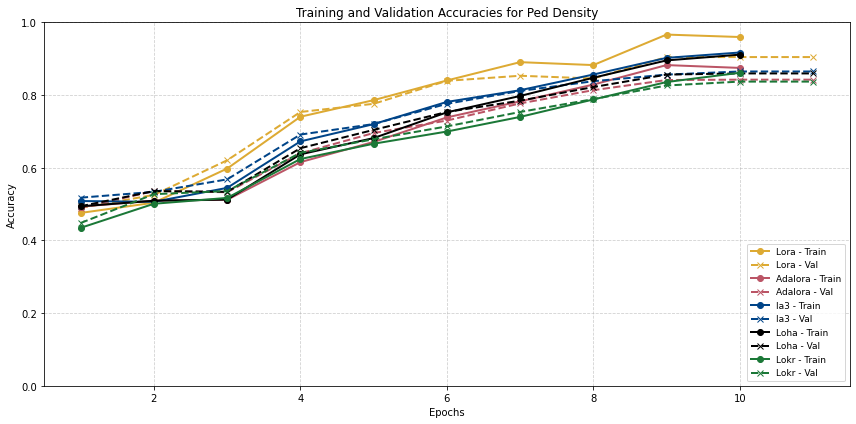

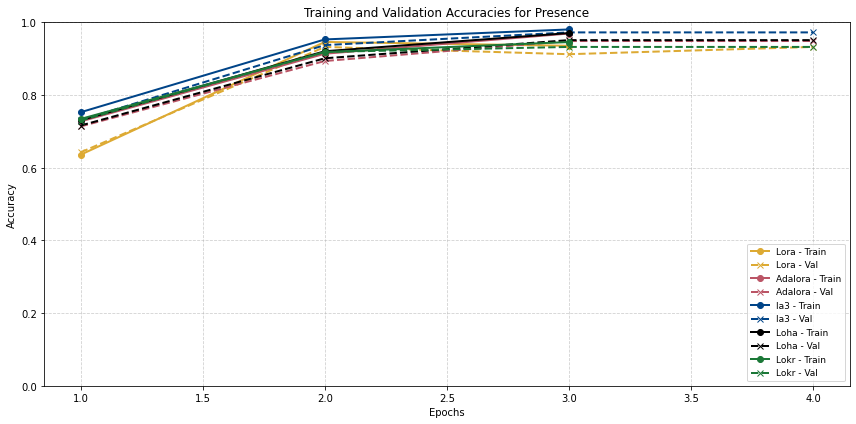

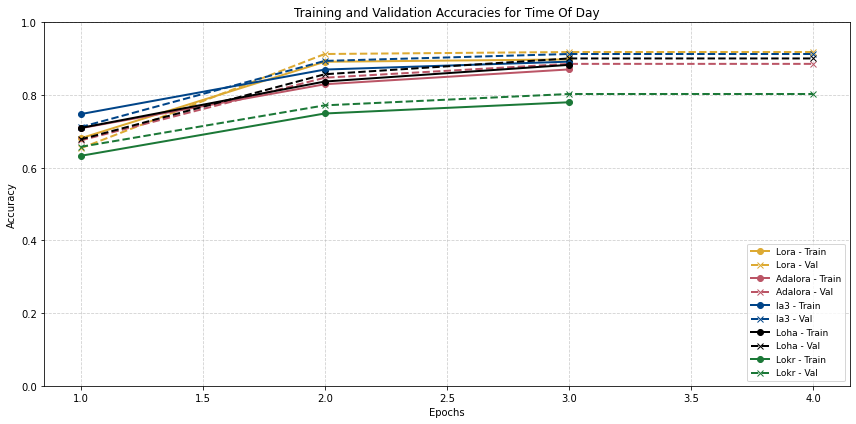

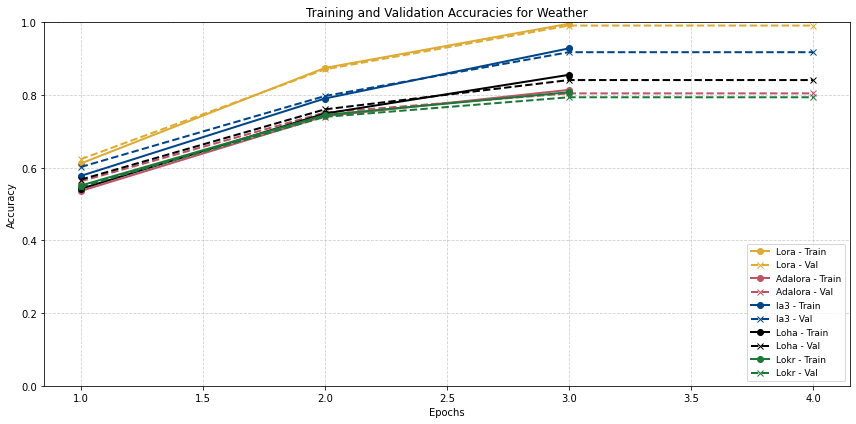

In [23]:
colors = ['#DDAA33', '#BB5566', '#004488', '#000000', '#1B7837', '#117733', '#88CCEE']

def plot_accuracies_per_epoch(metrics_storage):
    max_epochs = max(
        max(len(metrics.get('train_accuracy', [])), len(metrics.get('eval_accuracy', [])))
        for lora_metrics in metrics_storage.values() for metrics in lora_metrics.values()
    )
    for adapter_name, lora_metrics in metrics_storage.items():
        fig, ax = plt.subplots(figsize=(12, 6)) 
        for i, (lora_type, metrics) in enumerate(lora_metrics.items()):
            train_accuracies = metrics.get('train_accuracy', [])
            val_accuracies = metrics.get('eval_accuracy', [])
            train_accuracies = np.array(train_accuracies + [np.nan] * (max_epochs - len(train_accuracies)))
            val_accuracies = np.array(val_accuracies + [np.nan] * (max_epochs - len(val_accuracies)))
            epochs = np.arange(1, max_epochs + 1)  # Epoch numbers
            ax.plot(epochs, train_accuracies, marker='o', linestyle='-', 
                    label=f'{lora_type.capitalize()} - Train', 
                    color=colors[i % len(colors)], linewidth=2)

            ax.plot(epochs, val_accuracies, marker='x', linestyle='--', 
                    label=f'{lora_type.capitalize()} - Val', 
                    color=colors[i % len(colors)], linewidth=2)

        ax.set_xlabel('Epochs')
        ax.set_ylabel('Accuracy')
        ax.set_ylim(0, 1) 
        ax.set_title(f'Training and Validation Accuracies for {adapter_name.replace("_ADAPTER_MODEL", "").replace("_", " ").title()}')
        ax.legend(loc='lower right', fontsize=9)
        ax.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()

plot_accuracies_per_epoch(metrics_storage)

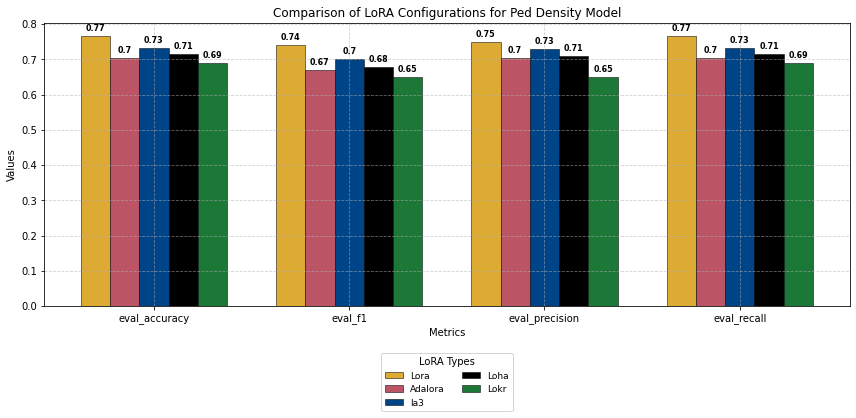

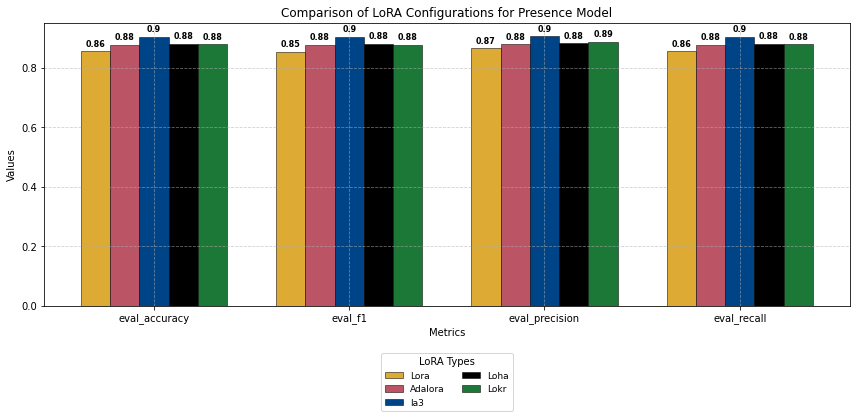

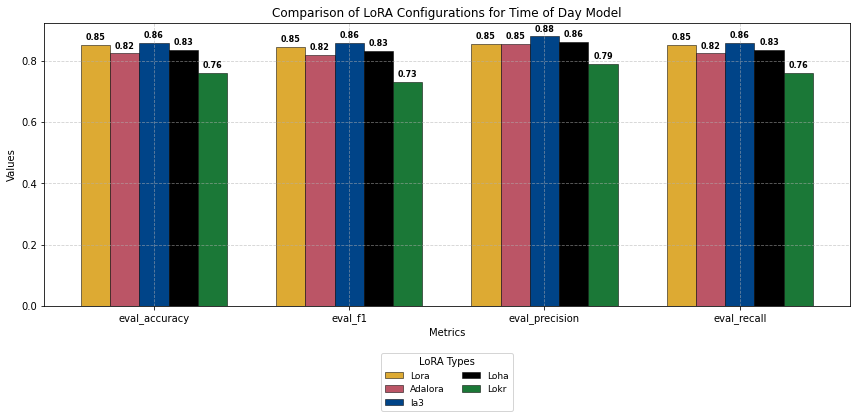

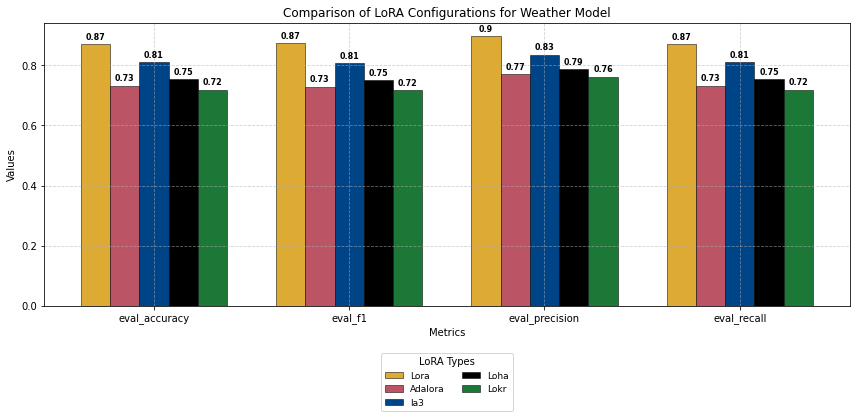

In [24]:
import matplotlib.pyplot as plt
import numpy as np

def plot_metrics_per_adapter(metrics_storage, metric_labels):
    display_names = {
        "PED_DENSITY_ADAPTER_MODEL": "Ped Density Model",
        "PRESENCE_ADAPTER_MODEL": "Presence Model",
        "TIME_OF_DAY_ADAPTER_MODEL": "Time of Day Model",
        "WEATHER_ADAPTER_MODEL": "Weather Model"
    }
    colors = ['#DDAA33', '#BB5566', '#004488', '#000000', '#1B7837']
    while len(colors) < len(adapter_configs):
        colors += colors  

    bar_width = 0.15  
    n_metrics = len(metric_labels)
    for adapter_name, lora_metrics in metrics_storage.items():
        fig, ax = plt.subplots(figsize=(12, 6)) 

        lora_names = list(lora_metrics.keys())  
        n_lora_types = len(lora_names) 

        index = np.arange(n_metrics) 
        for i, lora_type in enumerate(lora_names):
            metric_values = [
                np.mean(lora_metrics[lora_type].get(metric, [0])) for metric in metric_labels
            ]
            bars = ax.bar(
                index + i * bar_width, metric_values, bar_width,
                label=lora_type.capitalize(),
                color=colors[i % len(colors)], edgecolor='black', linewidth=0.5
            )
            for bar, value in zip(bars, metric_values):
                yval = round(value, 2)
                ax.text(
                    bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01,
                    yval, ha='center', va='bottom', fontsize=8, fontweight='bold'
                )
        ax.set_xlabel('Metrics')
        ax.set_ylabel('Values')
        ax.set_title(f'Comparison of LoRA Configurations for {display_names.get(adapter_name, adapter_name)}')
        ax.set_xticks(index + bar_width * (n_lora_types - 1) / 2)
        ax.set_xticklabels(metric_labels)
        ax.legend(title='LoRA Types', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, fontsize=9)
        ax.grid(True, linestyle='--', alpha=0.6) 
        plt.tight_layout()
        plt.show()

metric_labels = ["eval_accuracy", "eval_f1", "eval_precision", "eval_recall"]
plot_metrics_per_adapter(metrics_storage, metric_labels)

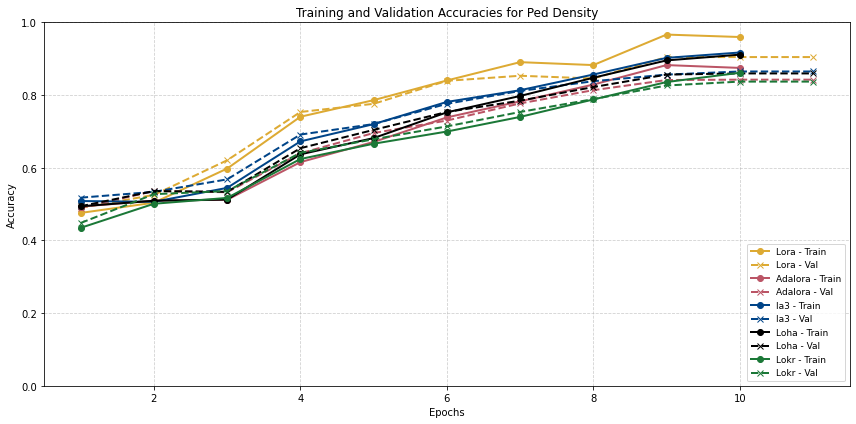

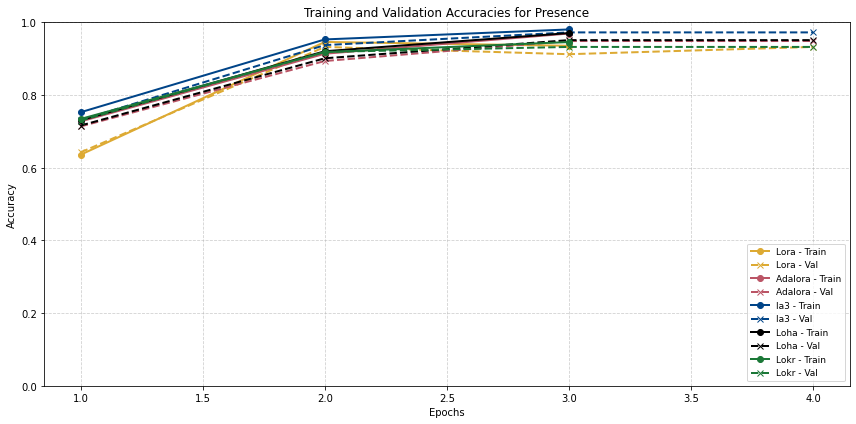

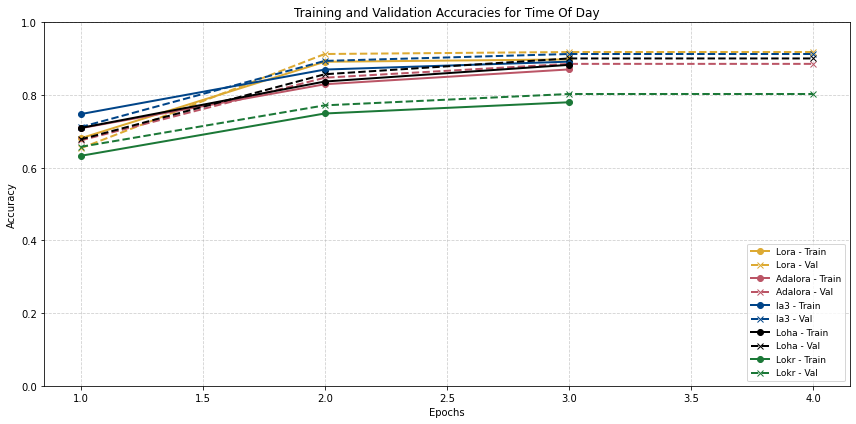

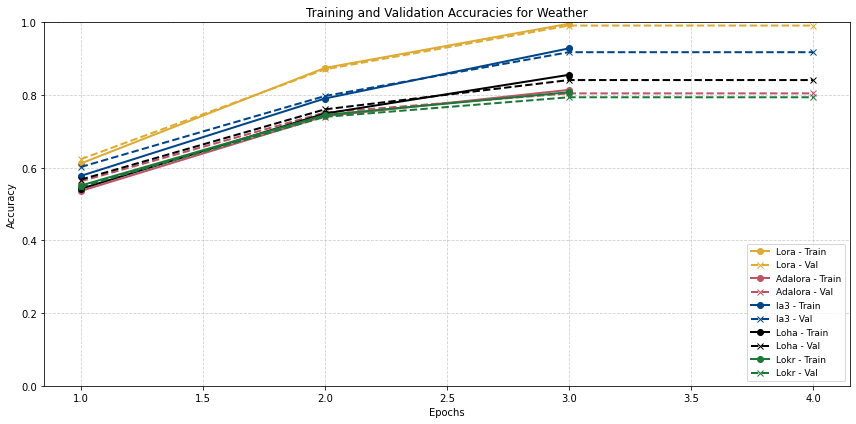

In [25]:
colors = ['#DDAA33', '#BB5566', '#004488', '#000000', '#1B7837', '#117733', '#88CCEE']
def plot_accuracies_per_epoch(metrics_storage):
    max_epochs = max(
        max(len(metrics.get('train_accuracy', [])), len(metrics.get('eval_accuracy', [])))
        for lora_metrics in metrics_storage.values() for metrics in lora_metrics.values()
    )
    for adapter_name, lora_metrics in metrics_storage.items():
        fig, ax = plt.subplots(figsize=(12, 6))
        for i, (lora_type, metrics) in enumerate(lora_metrics.items()):
            train_accuracies = metrics.get('train_accuracy', [])
            val_accuracies = metrics.get('eval_accuracy', [])
            train_accuracies = np.array(train_accuracies + [np.nan] * (max_epochs - len(train_accuracies)))
            val_accuracies = np.array(val_accuracies + [np.nan] * (max_epochs - len(val_accuracies)))
            epochs = np.arange(1, max_epochs + 1)
            ax.plot(epochs, train_accuracies, marker='o', linestyle='-', 
                    label=f'{lora_type.capitalize()} - Train', 
                    color=colors[i % len(colors)], linewidth=2)
            ax.plot(epochs, val_accuracies, marker='x', linestyle='--', 
                    label=f'{lora_type.capitalize()} - Val', 
                    color=colors[i % len(colors)], linewidth=2)
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Accuracy')
        ax.set_ylim(0, 1)
        ax.set_title(f'Training and Validation Accuracies for {adapter_name.replace("_ADAPTER_MODEL", "").replace("_", " ").title()}')
        ax.legend(loc='lower right', fontsize=9)
        ax.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()
plot_accuracies_per_epoch(metrics_storage)

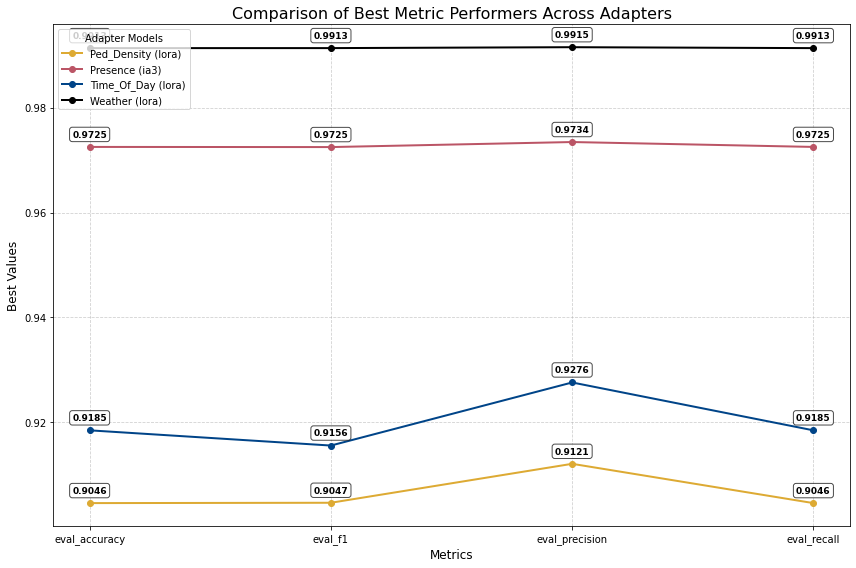

In [26]:
def get_best_metrics(metrics_storage, metric_labels):
    best_metrics = {}
    for adapter_name, lora_metrics in metrics_storage.items():
        best_metrics[adapter_name] = {"lora_type": None, "metrics": {}}
        best_value = -np.inf
        best_lora_type = None
        for lora_type, metrics in lora_metrics.items():
            metric_values = metrics.get(metric_labels[0].lower(), [])
            if metric_values:
                max_value = max(metric_values)
                if max_value > best_value:
                    best_value = max_value
                    best_lora_type = lora_type
        best_metrics[adapter_name]["lora_type"] = best_lora_type
        for metric in metric_labels:
            metric_values = lora_metrics[best_lora_type].get(metric.lower(), [])
            best_metrics[adapter_name]["metrics"][metric] = max(metric_values) if metric_values else None
    return best_metrics


def plot_comparison_of_best_performers(best_metrics, metric_labels):
    fig, ax = plt.subplots(figsize=(12, 8))
    colors = ['#DDAA33', '#BB5566', '#004488', '#000000', '#1B7837']
    for i, (adapter_name, data) in enumerate(best_metrics.items()):
        lora_type = data["lora_type"]
        values = [data["metrics"][metric] for metric in metric_labels]
        ax.plot(
            metric_labels, values, marker='o',
            label=f"{adapter_name.replace('_ADAPTER_MODEL', '').title()} ({lora_type})",
            linewidth=2, color=colors[i % len(colors)]  
        )
        for idx, (x, y) in enumerate(zip(metric_labels, values)):
            if y is not None:
                ax.annotate(
                    f"{y:.4f}",
                    xy=(x, y),
                    xytext=(0, 10),  
                    textcoords='offset points',  
                    fontsize=9, fontweight='bold', ha='center',
                    bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white', alpha=0.7)
                )

    ax.set_xlabel('Metrics', fontsize=12)
    ax.set_ylabel('Best Values', fontsize=12)
    ax.set_title('Comparison of Best Metric Performers Across Adapters', fontsize=16)
    ax.legend(title='Adapter Models', loc='upper left', fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

    
metric_labels = ["eval_accuracy", "eval_f1", "eval_precision", "eval_recall"]
best_metrics = get_best_metrics(metrics_storage, metric_labels)
plot_comparison_of_best_performers(best_metrics, metric_labels)


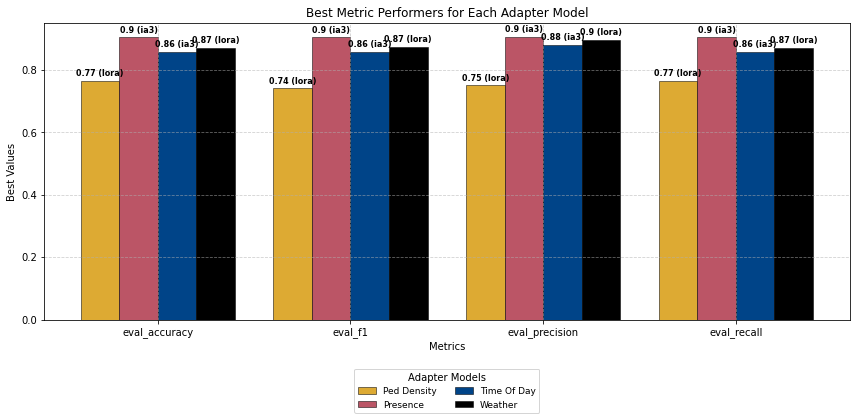

In [27]:
import matplotlib.pyplot as plt
import numpy as np

colors = ['#DDAA33', '#BB5566', '#004488', '#000000', '#1B7837']

def get_best_performers(metrics_storage, metric_labels):
    best_metrics = {}
    for adapter_name, lora_metrics in metrics_storage.items():
        best_metrics[adapter_name] = {}
        for metric in metric_labels:
            best_value = -np.inf 
            best_lora_type = None
            for lora_type, metrics in lora_metrics.items():
                value = np.mean(metrics.get(metric, 0)) if isinstance(metrics.get(metric, 0), list) else metrics.get(metric, 0)
                if value > best_value:
                    best_value = value
                    best_lora_type = lora_type
            best_metrics[adapter_name][metric] = (best_value, best_lora_type)
    return best_metrics

def plot_best_performers(best_metrics, metric_labels):
    bar_width = 0.2
    index = np.arange(len(metric_labels))  # X-axis positions for metrics
    n_adapters = len(best_metrics)
    fig, ax = plt.subplots(figsize=(12, 6))
    for i, (adapter_name, metrics) in enumerate(best_metrics.items()):
        metric_values = [metrics[metric][0] for metric in metric_labels]
        lora_types = [metrics[metric][1] for metric in metric_labels]
        adjusted_index = index + i * bar_width
        bars = ax.bar(
            adjusted_index, metric_values, bar_width,
            label=adapter_name.replace('_ADAPTER_MODEL', '').replace('_', ' ').title(),
            color=colors[i % len(colors)], edgecolor='black', linewidth=0.5
        )
        for bar, value, lora_type in zip(bars, metric_values, lora_types):
            yval = round(value, 2)
            ax.text(
                bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01,
                f"{yval} ({lora_type})", ha='center', va='bottom',
                fontsize=8, fontweight='bold'
            )
    ax.set_xlabel('Metrics')
    ax.set_ylabel('Best Values')
    ax.set_title('Best Metric Performers for Each Adapter Model')
    ax.set_xticks(index + bar_width * (n_adapters - 1) / 2)
    ax.set_xticklabels(metric_labels)
    ax.legend(title='Adapter Models', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, fontsize=9)
    ax.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

metric_labels = ["eval_accuracy", "eval_f1", "eval_precision", "eval_recall"]
best_metrics = get_best_performers(metrics_storage, metric_labels)
plot_best_performers(best_metrics, metric_labels)

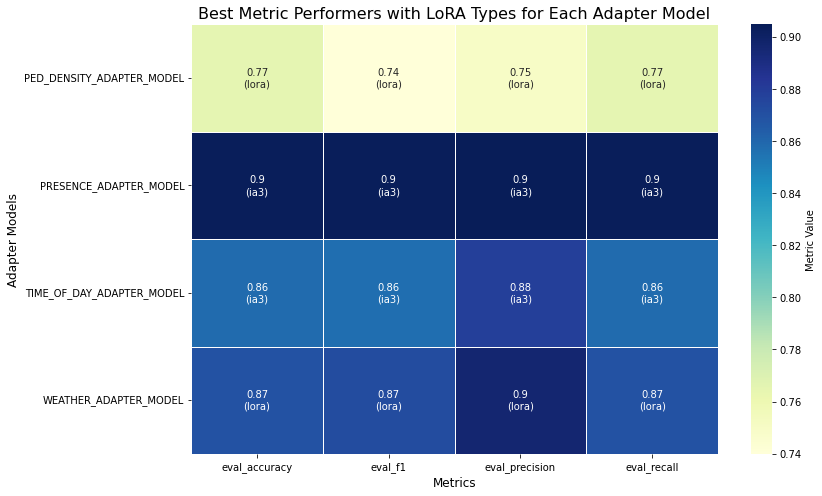

In [28]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

def plot_heatmap_with_lora_types(best_metrics, metric_labels):
    data = []
    annotations = [] 
    for adapter_name, metrics in best_metrics.items():
        row = []
        row_annotations = []
        for metric in metric_labels:
            value, lora_type = metrics[metric]
            row.append(value)
            row_annotations.append(f"{round(value, 2)}\n({lora_type})")  # Value + LoRA type
        data.append(row)
        annotations.append(row_annotations)

    df = pd.DataFrame(data, index=best_metrics.keys(), columns=metric_labels)
    plt.figure(figsize=(12, 7))
    ax = sns.heatmap(df, annot=annotations, fmt="", cmap='YlGnBu', 
                     linewidths=0.5, cbar_kws={'label': 'Metric Value'})
    plt.title('Best Metric Performers with LoRA Types for Each Adapter Model', fontsize=16)
    plt.xlabel('Metrics', fontsize=12)
    plt.ylabel('Adapter Models', fontsize=12)
    plt.tight_layout()
    plt.show()
    
plot_heatmap_with_lora_types(best_metrics, metric_labels)

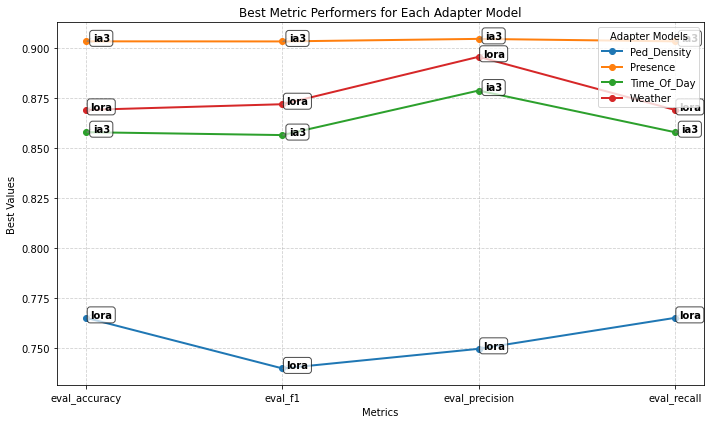

In [29]:
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np

def plot_line_chart(best_metrics, metric_labels):
    fig, ax = plt.subplots(figsize=(10, 6))
    annotation_positions = defaultdict(lambda: defaultdict(list))
    for adapter_name, metrics in best_metrics.items():
        values = [metrics[metric][0] for metric in metric_labels]
        lora_types = [metrics[metric][1] for metric in metric_labels]
        ax.plot(
            metric_labels, values, marker='o',
            label=adapter_name.replace('_ADAPTER_MODEL', '').title(),
            linewidth=2
        )
        for idx, (x, y, lora_type) in enumerate(zip(metric_labels, values, lora_types)):
            annotations_at_point = annotation_positions[x][y]
            annotations_at_point.append(lora_type)
            angle = np.pi * 2 * (len(annotations_at_point) - 1) / max(1, 6)
            offset_x = 15 * np.cos(angle) 
            offset_y = 15 * np.sin(angle) 
            ax.annotate(
                f"{lora_type}",
                xy=(x, y),
                xytext=(offset_x, offset_y), 
                textcoords='offset points',  
                fontsize=10, fontweight='bold', ha='center',
                bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white', alpha=0.7),
                arrowprops=dict(arrowstyle='->', color='gray', alpha=0.6) 
            )

    ax.set_xlabel('Metrics')
    ax.set_ylabel('Best Values')
    ax.set_title('Best Metric Performers for Each Adapter Model')
    ax.legend(title='Adapter Models', loc='upper right')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

plot_line_chart(best_metrics, metric_labels)